In [1]:
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_numeric_dtype
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, f1_score, make_scorer, ConfusionMatrixDisplay

Estamos refinando o conjunto de dados principal para atender a um objetivo comercial claro: criar um modelo que preveja o resultado acad√™mico final de um aluno. Para fazer isso de forma eficaz, o modelo deve ser treinado em dados com resultados hist√≥ricos confirmados. Os registros de alunos que ainda est√£o ‚ÄúMatriculados‚Äù representam um status incerto, em andamento, e n√£o um resultado final. A inclus√£o dessa ambiguidade introduziria ru√≠do e comprometeria a capacidade do modelo de aprender os padr√µes distintos que diferenciam os alunos que acabam se formando dos que desistem.


O arquivo exportado que cont√©m os alunos ‚Äúmatriculados‚Äù √© preservado para a aplica√ß√£o principal do modelo. Depois que nosso modelo for treinado e validado nos dados hist√≥ricos, n√≥s o usaremos para prever os resultados futuros para esse grupo de ‚Äúmatriculados‚Äù. Isso nos permite gerar uma pontua√ß√£o de risco de evas√£o para cada aluno ativo no momento, permitindo que a institui√ß√£o identifique proativamente indiv√≠duos em risco e implemente interven√ß√µes direcionadas para melhorar a reten√ß√£o.

In [2]:
df = pd.read_csv('./data/dataset.csv')

enrolled_df = df[df['Target'] == 'Enrolled'].copy()
enrolled_df.to_csv('./data/enrolled_students.csv', index=False)

df = df[df['Target'] != 'Enrolled']

cols_to_convert_to_category = [
    'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
    'Previous qualification', 'Nacionality', "Mother's qualification", 
    "Father's qualification", "Mother's occupation", "Father's occupation", 
    'Displaced', 'Educational special needs', 'Debtor', "Target",
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

for col in cols_to_convert_to_category:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Analise Explorat√≥ria dos Dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  3630 non-null   category
 1   Application mode                                3630 non-null   category
 2   Application order                               3630 non-null   int64   
 3   Course                                          3630 non-null   category
 4   Daytime/evening attendance                      3630 non-null   category
 5   Previous qualification                          3630 non-null   category
 6   Nacionality                                     3630 non-null   category
 7   Mother's qualification                          3630 non-null   category
 8   Father's qualification                          3630 non-null   category
 9   Mother's occupation                

In [4]:
df.describe()

Application order  Age at enrollment  \
count        3630.000000        3630.000000   
mean            1.750138          23.461157   
std             1.333831           7.827994   
min             0.000000          17.000000   
25%             1.000000          19.000000   
50%             1.000000          20.000000   
75%             2.000000          25.000000   
max             6.000000          70.000000   

       Curricular units 1st sem (credited)  \
count                          3630.000000   
mean                              0.754270   
std                               2.477277   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              20.000000   

       Curricular units 1st sem (enrolled)  \
count                          3630.000000   
mean                              6.337466   
std                               2.570773   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              26.000000   

       Curricular units 1st sem (evaluations)  \
count                             3630.000000   
mean                                 8.071074   
std                                  4.286632   
min                                  0.000000   
25%                                  6.000000   
50%                                  8.000000   
75%                                 10.000000   
max                                 45.000000   

       Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
count                          3630.000000                       3630.000000   
mean                              4.791460                         10.534860   
std                               3.237845                          5.057694   
min                               0.000000                          0.000000   
25%                               3.000000                         11.000000   
50%                               5.000000                         12.341429   
75%                               6.000000                         13.500000   
max                              26.000000                         18.875000   

       Curricular units 1st sem (without evaluations)  \
count                                     3630.000000   
mean                                         0.128926   
std                                          0.679111   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                         12.000000   

       Curricular units 2nd sem (credited)  \
count                          3630.000000   
mean                              0.581818   
std                               2.022688   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              19.000000   

       Curricular units 2nd sem (enrolled)  \
count                          3630.000000   
mean                              6.296419   
std                               2.263020   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              23.000000   

       Curricular units 2nd sem (evaluations)  \
count                             3630.000000   
mean                                 7.763085   
std                                  3.964163   
min                                  0.000000   
2

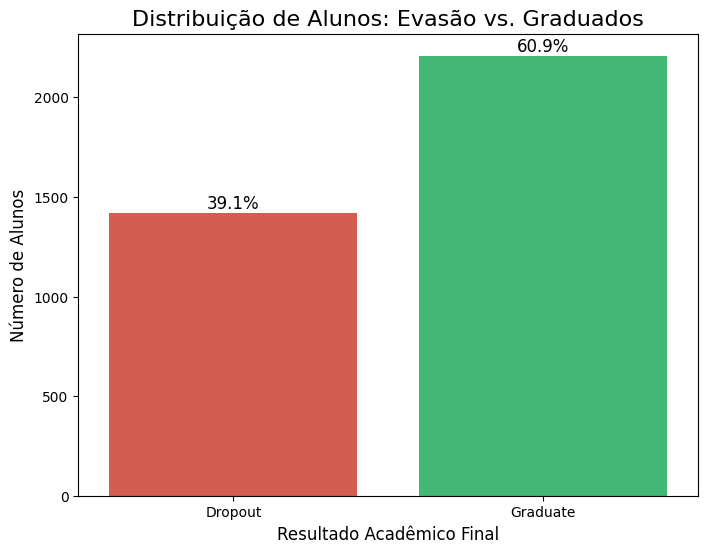

In [5]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Target', data=df, palette=['#E74C3C', '#2ECC71'])

plt.title('Distribui√ß√£o de Alunos: Evas√£o vs. Graduados', fontsize=16)
plt.xlabel('Resultado Acad√™mico Final', fontsize=12)
plt.ylabel('N√∫mero de Alunos', fontsize=12)

total = len(df['Target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

Este gr√°fico mostra a propor√ß√£o exata entre evas√µes e formaturas. As classes est√£o muito desbalanceadas (ex: 60.9% de graduados e 39.1% de evas√£o), talvez seja necess√°rio usar t√©cnicas de amostragem (como SMOTE ou ADASYN), m√©tricas de avalia√ß√£o espec√≠ficas (como F1-Score) e uso de peso de classes durante a modelagem.

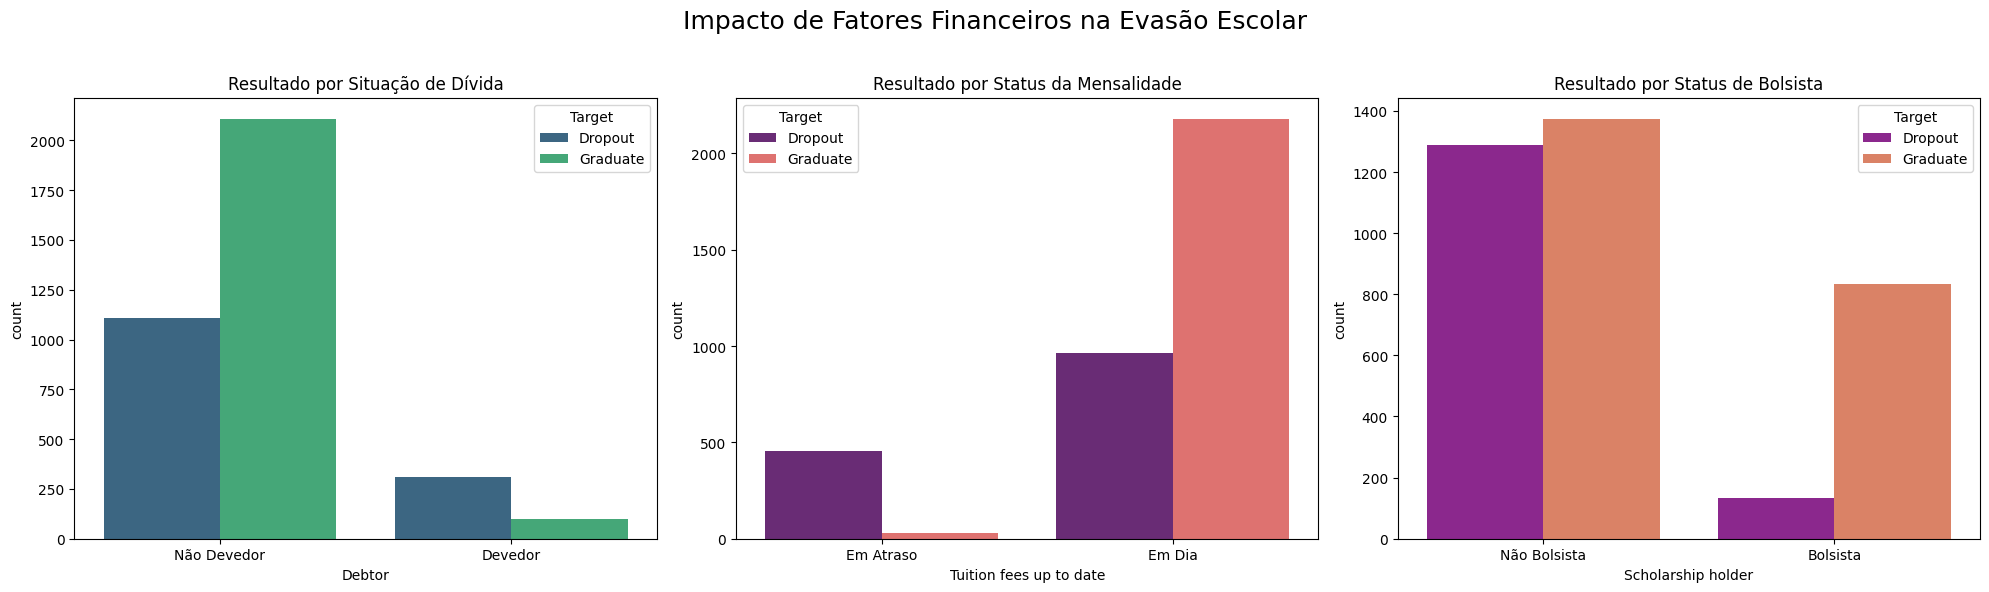

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Impacto de Fatores Financeiros na Evas√£o Escolar', fontsize=18)

sns.countplot(ax=axes[0], x='Debtor', hue='Target', data=df, palette='viridis')
axes[0].set_title('Resultado por Situa√ß√£o de D√≠vida')
axes[0].set_xticklabels(['N√£o Devedor', 'Devedor'])

sns.countplot(ax=axes[1], x='Tuition fees up to date', hue='Target', data=df, palette='magma')
axes[1].set_title('Resultado por Status da Mensalidade')
axes[1].set_xticklabels(['Em Atraso', 'Em Dia'])

sns.countplot(ax=axes[2], x='Scholarship holder', hue='Target', data=df, palette='plasma')
axes[2].set_title('Resultado por Status de Bolsista')
axes[2].set_xticklabels(['N√£o Bolsista', 'Bolsista'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Os gr√°ficos mostram que ter d√≠vidas ou mensalidades em atraso est√° fortemente correlacionado com a evas√£o. Por outro lado, ser bolsista tende a estar associado a uma maior taxa de gradua√ß√£o, possivelmente por reduzir a press√£o financeira e selecionar alunos com bom desempenho.

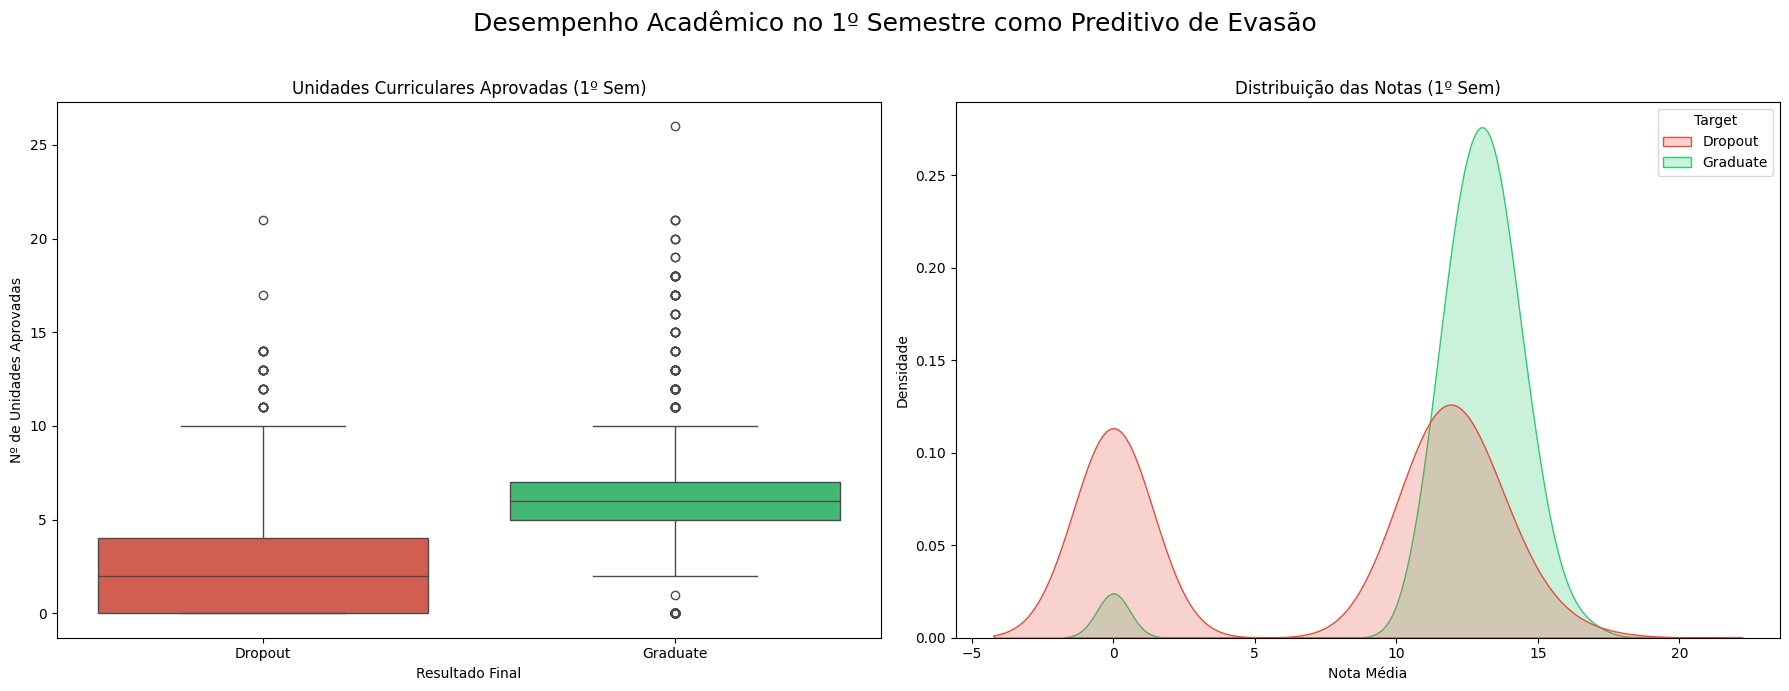

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Desempenho Acad√™mico no 1¬∫ Semestre como Preditivo de Evas√£o', fontsize=18)

sns.boxplot(ax=axes[0], x='Target', y='Curricular units 1st sem (approved)', data=df, palette=['#E74C3C', '#2ECC71'])
axes[0].set_title('Unidades Curriculares Aprovadas (1¬∫ Sem)')
axes[0].set_xlabel('Resultado Final')
axes[0].set_ylabel('N¬∫ de Unidades Aprovadas')


sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', hue='Target',
            fill=True, common_norm=False, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Distribui√ß√£o das Notas (1¬∫ Sem)')
axes[1].set_xlabel('Nota M√©dia')
axes[1].set_ylabel('Densidade')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Fica evidente que alunos que aprovam mais mat√©rias e t√™m notas mais altas logo no primeiro semestre t√™m uma chance muito maior de se graduar. Uma baixa contagem de aprova√ß√µes √© um forte sinal de alerta precoce para a evas√£o.

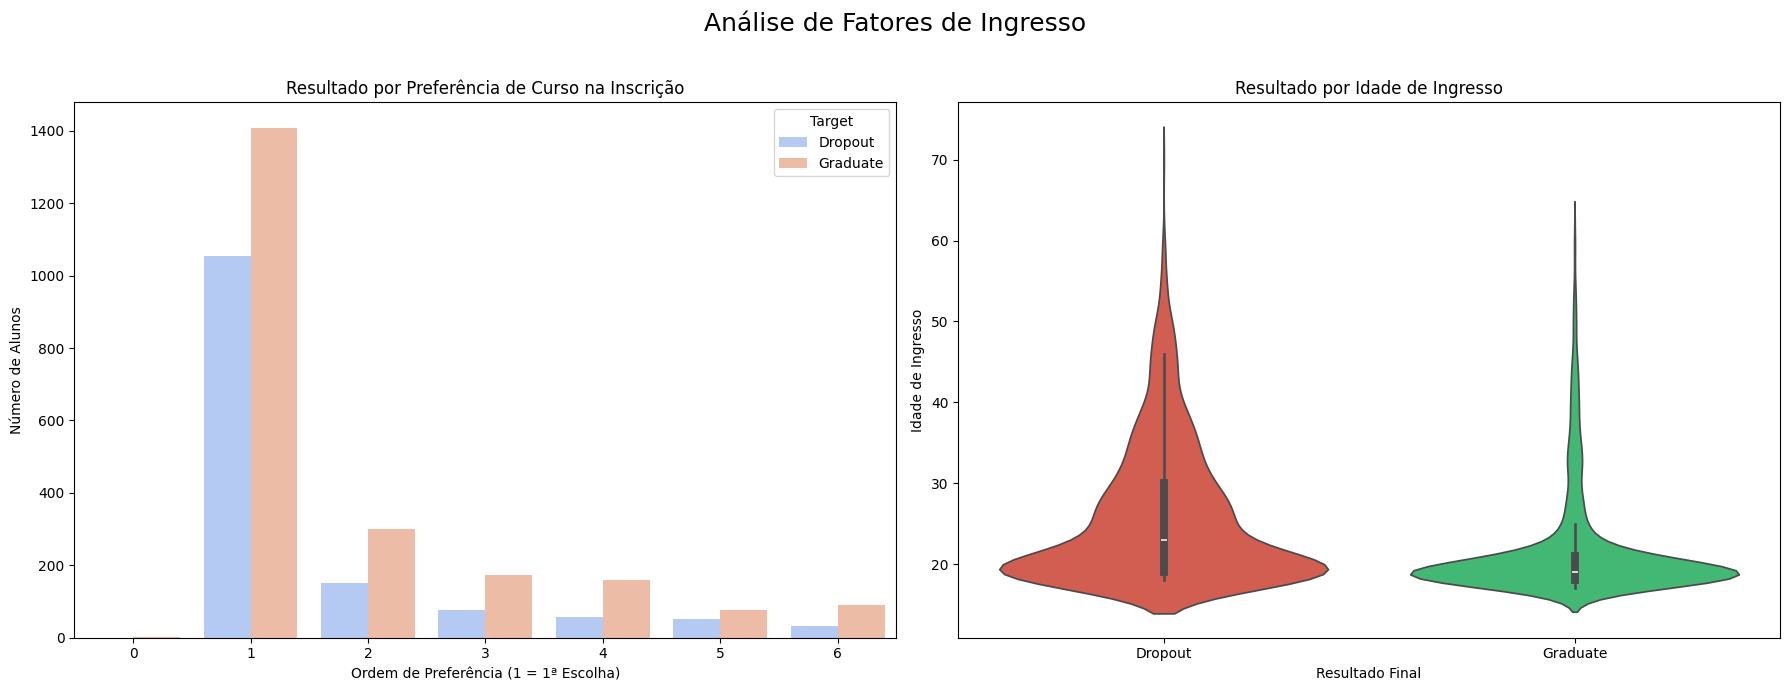

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('An√°lise de Fatores de Ingresso', fontsize=18)

sns.countplot(ax=axes[0], x='Application order', hue='Target', data=df, palette='coolwarm')
axes[0].set_title('Resultado por Prefer√™ncia de Curso na Inscri√ß√£o')
axes[0].set_xlabel('Ordem de Prefer√™ncia (1 = 1¬™ Escolha)')
axes[0].set_ylabel('N√∫mero de Alunos')

sns.violinplot(ax=axes[1], x='Target', y='Age at enrollment', data=df, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Resultado por Idade de Ingresso')
axes[1].set_xlabel('Resultado Final')
axes[1].set_ylabel('Idade de Ingresso')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Alunos que entram no curso de primeira escolha (Application order = 1) intuitivamente tendem a ser mais motivados e, consequentemente, t√™m uma taxa de evas√£o menor, mas o grafico acima nos mostra que a propor√ß√£o de graduados e evas√£o continua a mesma quanto aumenta a Ordem de Prefer√™ncia. A an√°lise de idade pode revelar que alunos mais velhos (mature students) tem taxas de evas√£o ligeiramente maiores, talvez por terem que conciliar trabalho, estudo, fam√≠lia e outras responsabilidades que se tem quando √© mais velho.

## Analise Estat√≠stica

| Tipo de vari√°vel 1 | Tipo de vari√°vel 2 | Teste recomendado | Observa√ß√£o |
| :--- | :--- | :--- | :--- |
| Categ√≥rica | Categ√≥rica | Qui-quadrado (Chi-square) | Testa independ√™ncia entre categorias |
| Num√©rica | Num√©rica | Correla√ß√£o de Pearson (ou Spearman para n√£o param√©trico) | Mede for√ßa e dire√ß√£o da rela√ß√£o linear |
| Categ√≥rica | Num√©rica | ANOVA (ou teste t para 2 grupos) | Testa diferen√ßa das m√©dias da num√©rica entre grupos categ√≥ricos |
| Num√©rica | Categ√≥rica | ANOVA (mesma situa√ß√£o acima, s√≥ invertendo) | O teste √© sim√©trico neste caso |
| Categ√≥rica (target) | Num√©rica | Modelos de classifica√ß√£o (e.g., regress√£o log√≠stica) e testes espec√≠ficos | ANOVA n√£o √© indicado para associa√ß√£o com target categ√≥rico |
| Num√©rica (target) | Categ√≥rica | ANOVA (comparar m√©dias entre grupos da categ√≥rica) | Cl√°ssico caso para ANOVA |

### Matriz de correla√ß√£o de Pearson (Entre vari√°veis n√∫mericas)

√â uma tabela que mostra o grau de associa√ß√£o linear entre pares de vari√°veis num√©ricas.

Ela usa o coeficiente de correla√ß√£o de Pearson (r) para medir quanto duas vari√°veis se movem juntas, ou seja, o quanto aumentos ou diminui√ß√µes em uma vari√°vel se associam a aumentos ou diminui√ß√µes em outra.

| Valor de r | Interpreta√ß√£o |
| :--- | :--- |
| +1 | Correla√ß√£o linear positiva perfeita |
| 0 | Sem correla√ß√£o linear |
| -1 | Correla√ß√£o linear negativa perfeita |

**Importante**: Pearson s√≥ mede rela√ß√µes lineares. Duas vari√°veis podem ser dependentes n√£o-linearmente e ainda assim ter r ‚âà 0.

Para duas vari√°veis X e Y com n observa√ß√µes, o coeficiente de correla√ß√£o de Pearson r √© calculado como:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \cdot \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

Onde:
- $X·µ¢$ e $Y·µ¢$ s√£o os valores individuais das vari√°veis $X$ e $Y$
- $ùëãÃÑ$ e $ùëåÃÑ$ s√£o as m√©dias das vari√°veis $X$ e $Y$
- O numerador √© a covari√¢ncia entre $X$ e $Y$
- O denominador √© o produto dos desvios padr√£o de $X$ e $Y$

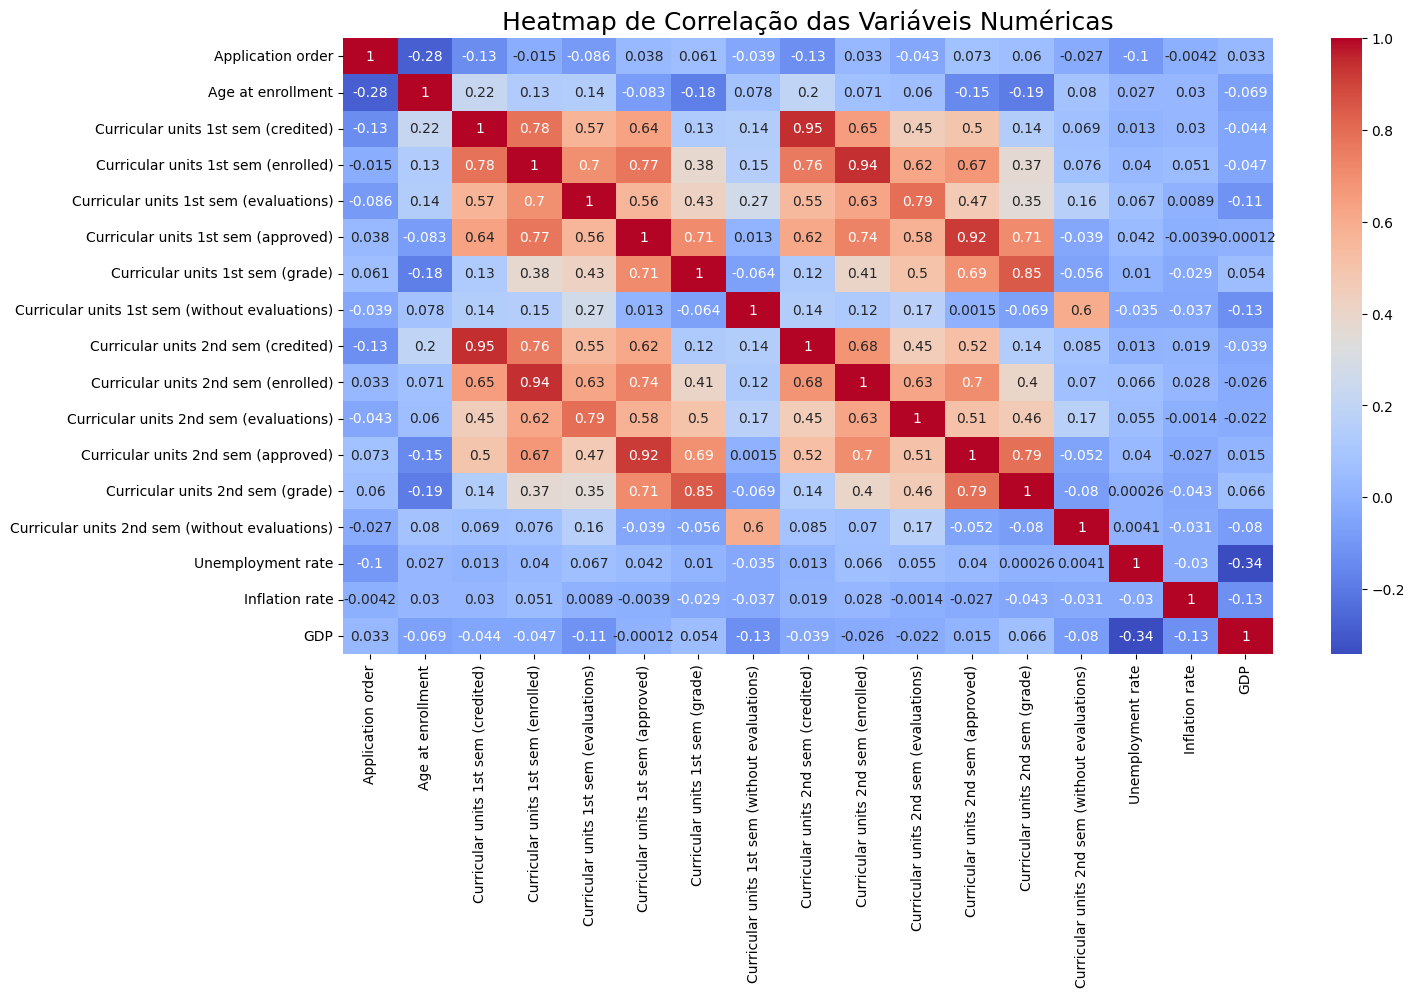

In [9]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Heatmap de Correla√ß√£o das Vari√°veis Num√©ricas', fontsize=18)
plt.show()

- **Dentro do mesmo semestre**: Vari√°veis como unidades matriculadas (enrolled), avaliadas (evaluations) e aprovadas (approved) s√£o fortemente correlacionadas. Isso √© l√≥gico: quem se matricula em mais mat√©rias tende a ter mais avalia√ß√µes e a ser aprovado em mais unidades. A nota do semestre (grade) tamb√©m tem uma correla√ß√£o muito forte com as unidades aprovadas (approved), com um valor de 0.71 no 1¬∫ semestre.

- **Entre semestres (Insight importante)**: A correla√ß√£o mais forte e importante √© entre o desempenho do 1¬∫ e do 2¬∫ semestre. A nota do 1¬∫ semestre (1st sem (grade)) tem uma correla√ß√£o de 0.85 com a do 2¬∫. Da mesma forma, as unidades aprovadas no 1¬∫ semestre t√™m correla√ß√£o de 0.92 com as do 2¬∫. Isso prova que o desempenho acad√™mico passado √© um preditor extremamente forte do desempenho futuro.

- **Poss√≠vel Multicolinearidade**: O "bloco quente" envolvendo as vari√°veis `Curricular units ...` s√£o um grande indicativo de multicolinearidade. Isso ser√° analisado posteriormente usando a t√©cnica de Fator de Infla√ß√£o de Vari√¢ncia (VIF).

### Testes de Hip√≥tese


#### ANOVA (An√°lise de Vari√¢ncia): 
Testa se existe uma diferen√ßa estatisticamente significativa entre as m√©dias de uma vari√°vel num√©rica em dois ou mais grupos de uma vari√°vel categ√≥rica

- **ANOVA pergunta**: "Essa vari√°vel categ√≥rica est√° associada a diferen√ßas significativas na m√©dia de uma vari√°vel cont√≠nua?"
    - Se sim, ela traz informa√ß√£o √∫til e pode ser uma boa candidata como vari√°vel explicativa.

1. **Hip√≥tese nula** ($H_0$):
    - N√£o h√° diferen√ßa significativa entre os grupos.
    - Ou seja: a vari√°vel categ√≥rica n√£o tem efeito sobre a vari√°vel num√©rica.
    - As m√©dias dos grupos (categorias) s√£o iguais.

‚û° Isso implica que n√£o h√° associa√ß√£o estat√≠stica entre as vari√°veis. √â poss√≠vel considerar o descarte de uma das vari√°veis, ou realizar um feature engineering.

2. **Hip√≥tese alternativa** ($H_1$):
    - H√° pelo menos uma diferen√ßa significativa entre os grupos.
    - Ou seja: a vari√°vel categ√≥rica tem efeito sobre a vari√°vel num√©rica.
    - As m√©dias dos grupos s√£o diferentes.

‚û° Isso indica associa√ß√£o significativa entre a vari√°vel categ√≥rica e a num√©rica. Feature engineering pode n√£o ser necess√°ria nesse ponto, porque a rela√ß√£o j√° est√° clara, mas ainda pode valer a pena melhorar a representa√ß√£o.

- $p > 0.05$ >>> N√£o rejeita $H_0$ ‚Üí N√£o h√° evid√™ncia de diferen√ßa entre os grupos ‚Üí Sem associa√ß√£o
- $p ‚â§ 0.05$ >>> Rejeita $H_0$ e aceita $H_1$ ‚Üí Existe evid√™ncia de que os grupos diferem ‚Üí H√° associa√ß√£o

In [10]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

if 'Target' in categorical_features:
    categorical_features.remove('Target')

anova_results = []

for cat_col in categorical_features:
    for num_col in numerical_features:
        # Pular se a vari√°vel categ√≥rica tiver muitas categorias (torna o teste lento/ruim)
        if df[cat_col].nunique() > 50:
            continue
            
        # Agrupar os dados num√©ricos pelas categorias da vari√°vel categ√≥rica
        groups = df.groupby(cat_col)[num_col].apply(list)
        
        if len(groups) < 2:
            continue
        
        try:
            f_statistic, p_value = f_oneway(*groups)
            anova_results.append({
                'Vari√°vel Categ√≥rica': cat_col,
                'Vari√°vel Num√©rica': num_col,
                'Estat√≠stfor o n√∫cleoica F': f_statistic,
                'p-valor': p_value
            })
        except Exception as e:
            # Ignorar pares que causam erros (ex: grupos com dados insuficientes)
            pass

results_df = pd.DataFrame(anova_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Exibindo as 15 rela√ß√µes mais significativas:")
display(results_df_sorted.head(15))

print("Exibindo as 15 rela√ß√µes menos significativas:")
display(results_df_sorted.tail(15))


Exibindo as 15 rela√ß√µes mais significativas:


Vari√°vel Categ√≥rica                       Vari√°vel Num√©rica  \
18             Application mode                       Age at enrollment   
1                Marital status                       Age at enrollment   
43                       Course     Curricular units 2nd sem (enrolled)   
35                       Course                       Age at enrollment   
37                       Course     Curricular units 1st sem (enrolled)   
19             Application mode     Curricular units 1st sem (credited)   
69       Previous qualification                       Age at enrollment   
52   Daytime/evening attendance                       Age at enrollment   
25             Application mode     Curricular units 2nd sem (credited)   
40                       Course        Curricular units 1st sem (grade)   
103      Mother's qualification                       Age at enrollment   
45                       Course     Curricular units 2nd sem (approved)   
46                       Course        Curricular units 2nd sem (grade)   
38                       Course  Curricular units 1st sem (evaluations)   
171                   Displaced                       Age at enrollment   

     Estat√≠stfor o n√∫cleoica F        p-valor  
18                  280.745529   0.000000e+00  
1                   502.811925   0.000000e+00  
43                  118.447943  1.049518e-315  
35                   80.506006  6.580430e-225  
37                   72.907779  1.995195e-205  
19                   67.502645  1.850651e-201  
69                   71.022735  1.607919e-200  
52                  940.584260  7.200418e-184  
25                   58.741694  7.155714e-177  
40                   60.424144  2.246295e-172  
103                  31.446104  2.124312e-148  
45                   48.355566  4.011635e-139  
46                   45.525566  3.911730e-131  
38                   43.341239  6.445531e-125  
171                 575.518614  3.594256e-118

Exibindo as 15 rela√ß√µes menos significativas:


Vari√°vel Categ√≥rica  \
276               International   
280               International   
162         Father's occupation   
287               International   
265          Scholarship holder   
277               International   
67   Daytime/evening attendance   
253                      Gender   
202   Educational special needs   
97                  Nacionality   
91                  Nacionality   
275               International   
284               International   
160         Father's occupation   
278               International   

                                  Vari√°vel Num√©rica  \
276          Curricular units 1st sem (evaluations)   
280             Curricular units 2nd sem (credited)   
162             Curricular units 2nd sem (enrolled)   
287                                  Inflation rate   
265          Curricular units 2nd sem (evaluations)   
277             Curricular units 1st sem (approved)   
67                                              GDP   
253                                  Inflation rate   
202                                  Inflation rate   
97                 Curricular units 2nd sem (grade)   
91                 Curricular units 1st sem (grade)   
275             Curricular units 1st sem (enrolled)   
284                Curricular units 2nd sem (grade)   
160  Curricular units 1st sem (without evaluations)   
278                Curricular units 1st sem (grade)   

     Estat√≠stfor o n√∫cleoica F   p-valor  
276                   0.163568  0.685916  
280                   0.141132  0.707180  
162                   0.868774  0.707389  
287                   0.126691  0.721909  
265                   0.126421  0.722193  
277                   0.112094  0.737792  
67                    0.090973  0.762961  
253                   0.072378  0.787921  
202                   0.071908  0.788594  
97                    0.722345  0.791122  
91                    0.693223  0.821266  
275                   0.045439  0.831210  
284                   0.034109  0.853486  
160                   0.761847  0.863999  
278                   0.015341  0.901435

- **Idade de Ingresso (Age at enrollment) √© Central**: A idade do aluno √© a vari√°vel num√©rica mais influenciada por fatores categ√≥ricos. Ela est√° fortemente associada ao Estado Civil, Modo de Aplica√ß√£o, Curso, Qualifica√ß√£o Pr√©via e se o aluno √© Deslocado. Isso indica que diferentes perfis demogr√°ficos ingressam na universidade em idades significativamente diferentes, o que, por si s√≥, √© um poderoso agrupador de comportamento.

- **O Curso (Course) Define o Desempenho**: Como esperado, o curso escolhido tem um impacto massivo em todas as m√©tricas de desempenho acad√™mico: unidades matriculadas (enrolled), notas (grade) e unidades aprovadas (approved). Isso confirma que a dificuldade e a carga de trabalho variam drasticamente entre os cursos, tornando esta uma das features mais importantes para prever o sucesso de um aluno.

- **O Hist√≥rico Importa**: A Qualifica√ß√£o Pr√©via (Previous qualification) e o Modo de Aplica√ß√£o (Application mode) est√£o fortemente ligados tanto √† idade quanto aos cr√©ditos iniciais. Isso mostra que a "bagagem" que o aluno traz para a universidade j√° o coloca em uma trajet√≥ria de desempenho distinta.

- **Status de International √© um Preditor Fraco (Isoladamente)**: A descoberta mais not√°vel aqui √© que ser ou n√£o um estudante internacional n√£o tem uma associa√ß√£o estatisticamente significativa com quase nenhuma m√©trica de desempenho acad√™mico (notas, aprova√ß√µes, avalia√ß√µes). Isso sugere que, neste dataset, o desempenho dos alunos internacionais √© estatisticamente indistingu√≠vel do dos alunos nacionais, tornando essa vari√°vel, sozinha, um preditor fraco.

- **Demografia Secund√°ria com Baixo Impacto**: Vari√°veis como Ocupa√ß√£o do Pai (Father's occupation), Nacionalidade (Nacionality) e G√™nero (Gender), quando cruzadas com as m√©tricas num√©ricas, mostraram uma rela√ß√£o muito fraca (p-valor alto). Elas provavelmente t√™m menos poder preditivo direto do que as vari√°veis da primeira tabela.

- **Fatores Macroecon√¥micos Difusos**: A Taxa de Infla√ß√£o e o PIB n√£o se mostraram associados a caracter√≠sticas individuais como g√™nero ou nacionalidade, o que faz sentido, pois s√£o indicadores que afetam a todos de forma mais ampla e menos direta.


#### Qui-Quadrado

Este teste avalia se existe uma associa√ß√£o estatisticamente significativa entre duas vari√°veis categ√≥ricas. A hip√≥tese nula $H_0‚Äã$ √© que as vari√°veis s√£o independentes (n√£o h√° associa√ß√£o, com $p > 0.05$) e a hip√≥tese alternativa $H_1$ √© que existe uma associa√ß√£o ($p ‚â§ 0.05$).

O Qui-Quadrado consegue analisar associa√ß√µes entre a nossa vari√°vel Target (que √© categ√≥rica) e outras vari√°veis explicativas categ√≥ricas.

**OBS**: A ANOVA analisa o impacto de uma vari√°vel categ√≥rica nas m√©dias de uma vari√°vel num√©rica, A vari√°vel categ√≥rica define os grupos (por exemplo: `aprovado`, `reprovado`, `evadiu`), e a vari√°vel num√©rica √© a que est√° sendo analisada em rela√ß√£o √†s diferen√ßas entre esses grupos (ex: m√©dia de notas, horas de estudo, renda etc.). No nosso caso, queremos sabe se a vari√°vel categ√≥rica `Target` (evas√£o escolar) pode ser explicada por uma vari√°vel num√©rica (ex: renda, idade, nota), acontece que a ANOVA n√£o foi projetada para testar isso diretamente, porque o foco da ANOVA est√° na vari√°vel num√©rica como vari√°vel de interesse, e a categ√≥rica como vari√°vel explicativa, e n√£o o contr√°rio. O teste de **Qui-quadrado** entra para resolver esse problema.

Rela√ß√µes mais significativas:


Vari√°vel 1                  Vari√°vel 2  Estat√≠stica Chi2  \
20          Application mode                 Nacionality       3375.483418   
19          Application mode      Previous qualification      10302.630410   
33                    Course  Daytime/evening attendance       3630.000000   
108      Mother's occupation         Father's occupation      42264.249558   
87    Mother's qualification      Father's qualification      20115.447190   
85               Nacionality               International       3630.000000   
89    Mother's qualification         Father's occupation       5888.401307   
88    Mother's qualification         Mother's occupation       7165.054597   
99    Father's qualification         Father's occupation       5162.093150   
98    Father's qualification         Mother's occupation       3494.673706   
17          Application mode                      Course       1890.406812   
31          Application mode               International        914.612478   
146  Tuition fees up to date                      Target        706.955139   
0             Marital status            Application mode        996.484588   
138                   Debtor     Tuition fees up to date        682.572191   
25          Application mode                   Displaced        649.610140   
18          Application mode  Daytime/evening attendance        635.396069   
44                    Course                      Gender        620.290470   
2             Marital status  Daytime/evening attendance        465.493052   
47                    Course                      Target        442.947968   

           p-valor  
20    0.000000e+00  
19    0.000000e+00  
33    0.000000e+00  
108   0.000000e+00  
87    0.000000e+00  
85    0.000000e+00  
89    0.000000e+00  
88    0.000000e+00  
99    0.000000e+00  
98   3.329569e-294  
17   6.859661e-240  
31   1.606752e-183  
146  9.189124e-156  
0    1.831588e-155  
138  1.843163e-150  
25   4.355530e-127  
18   4.505609e-124  
44   1.132511e-121  
2     2.233328e-98  
47    3.497695e-84



Associa√ß√µes mais fortes com a vari√°vel 'Target':


Vari√°vel 1 Vari√°vel 2  Estat√≠stica Chi2        p-valor
146     Tuition fees up to date     Target        706.955139  9.189124e-156
47                       Course     Target        442.947968   3.497695e-84
151          Scholarship holder     Target        354.219302   5.109075e-79
32             Application mode     Target        392.065918   8.435153e-73
142                      Debtor     Target        257.459618   6.141424e-58
149                      Gender     Target        229.351510   8.255974e-52
74       Previous qualification     Target        150.599021   5.952453e-24
97       Mother's qualification     Target        143.014288   2.201217e-17
116         Mother's occupation     Target        138.235113   1.555138e-16
107      Father's qualification     Target        147.861704   1.754550e-16
131                   Displaced     Target         57.215216   3.906373e-14
124         Father's occupation     Target        125.427955   1.725336e-10
16               Marital status     Target         53.131403   3.160761e-10
61   Daytime/evening attendance     Target         25.371410   4.728747e-07
86                  Nacionality     Target         19.850806   3.412815e-01
137   Educational special needs     Target          0.075160   7.839673e-01
152               International     Target          0.067922   7.943867e-01

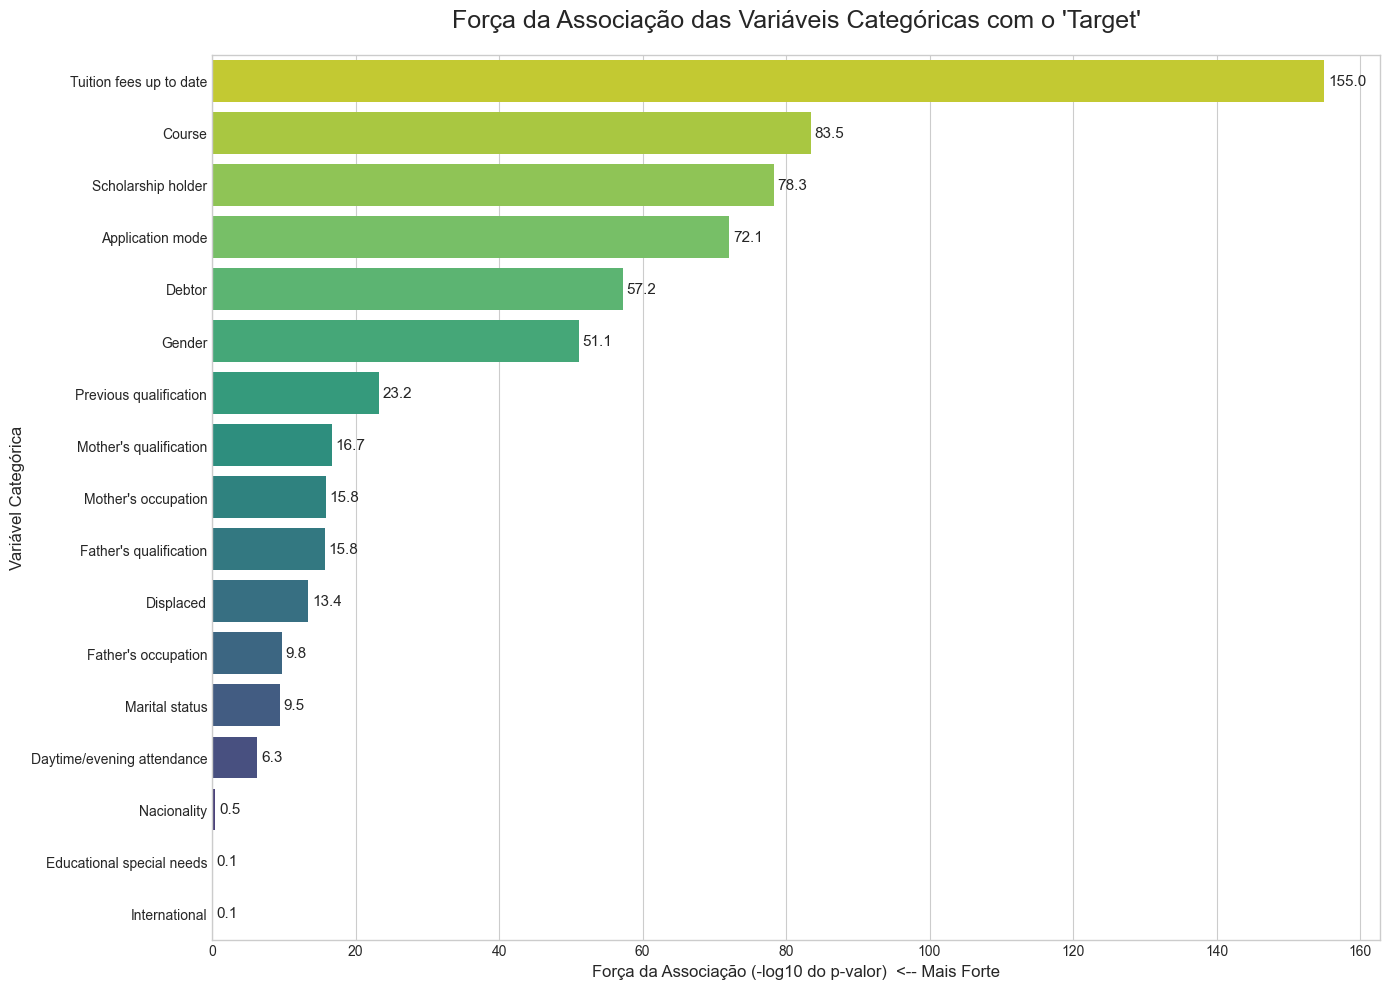

In [11]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_pairs = list(combinations(categorical_features, 2))
chi2_results = []

for pair in cat_pairs:
    var1, var2 = pair[0], pair[1]
    
    contingency_table = pd.crosstab(df[var1], df[var2])
    
    try:
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({
            'Vari√°vel 1': var1,
            'Vari√°vel 2': var2,
            'Estat√≠stica Chi2': chi2,
            'p-valor': p_value
        })
    except Exception as e:
        # Algumas tabelas podem ter contagens zero, o que pode falhar o teste
        pass

results_df = pd.DataFrame(chi2_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Rela√ß√µes mais significativas:")
display(results_df_sorted.head(20))

print("\n\nAssocia√ß√µes mais fortes com a vari√°vel 'Target':")
target_associations = results_df_sorted[
    (results_df_sorted['Vari√°vel 1'] == 'Target') | (results_df_sorted['Vari√°vel 2'] == 'Target')
].copy()
display(target_associations.head(20))

target_associations['Feature'] = target_associations.apply(
    lambda row: row['Vari√°vel 1'] if row['Vari√°vel 2'] == 'Target' else row['Vari√°vel 2'],
    axis=1
)

target_associations['For√ßa da Associa√ß√£o (-log10 p-valor)'] = -np.log10(target_associations['p-valor'].replace(0, 1e-300))

plot_data = target_associations.sort_values(by='For√ßa da Associa√ß√£o (-log10 p-valor)', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=plot_data,
    x='For√ßa da Associa√ß√£o (-log10 p-valor)',
    y='Feature',
    palette='viridis_r',
    orient='h'
)

ax.set_title("For√ßa da Associa√ß√£o das Vari√°veis Categ√≥ricas com o 'Target'", fontsize=18, pad=20)
ax.set_xlabel('For√ßa da Associa√ß√£o (-log10 do p-valor)  <-- Mais Forte', fontsize=12)
ax.set_ylabel('Vari√°vel Categ√≥rica', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2,
            f'{width:.1f}',
            va='center',
            fontsize=11)

plt.tight_layout()
plt.show()


##### Tier 1: Os Preditores Dominantes (p-valor $< e-50$)

Estas s√£o as vari√°veis com a conex√£o mais forte com a evas√£o. Elas devem estar presentes em qualquer modelo preditivo que for constru√≠do.

- **Tuition fees up to date (Mensalidades em dia)**: Com um p-valor astron√¥mico de aproximadamente $e^-156$, esta √©, de longe, a vari√°vel mais impactante. A associa√ß√£o √© t√£o forte que o status financeiro do aluno com a institui√ß√£o √© quase um veredito sobre seu resultado. A mensagem √© clara: dificuldade financeira √© a principal causa de evas√£o.

- **Course (Curso)**: A segunda vari√°vel mais forte. Confirma que o curso escolhido pelo aluno √© um fator determinante para seu sucesso. Alguns cursos podem ter taxas de evas√£o intrinsecamente mais altas devido √† dificuldade, estrutura ou alinhamento com o mercado.

- **Scholarship holder (Bolsista)**: Funciona como o oposto do status da mensalidade. Ter uma bolsa, que alivia a press√£o financeira e muitas vezes seleciona alunos de alto m√©rito, tem um efeito protetor massivo contra a evas√£o.

- **Application mode (Modo de Ingresso) e Debtor (Devedor)**: Completam este grupo de vari√°veis significativas. O caminho pelo qual o aluno entrou na universidade e seu status de d√≠vida s√£o fatores cr√≠ticos.

- **Gender (G√™nero)**: Surpreendentemente, G√™nero aparece com uma associa√ß√£o extremamente forte. Isso n√£o significa que um g√™nero seja "melhor" que o outro, mas sim que, neste dataset, os padr√µes de evas√£o e gradua√ß√£o entre homens e mulheres s√£o estatisticamente muito diferentes. Seria interessante investigar isso mais a fundo (ex: evas√£o por g√™nero dentro de cada curso).

Insight Principal do Tier 1: A sa√∫de financeira do aluno e suas escolhas acad√™micas prim√°rias s√£o os pilares que sustentam sua jornada na universidade.

##### Tier 2: Os Fatores de Contexto (p-valor entre $e-10$ e $e-24$)

Estas vari√°veis, embora n√£o t√£o dominantes quanto as do Tier 1, ainda s√£o preditores muito fortes e adicionam um √≥timo contexto sobre o perfil do aluno.

- **Qualifica√ß√£o e Ocupa√ß√£o dos Pais (Mother's/Father's qualification/occupation)**: Este bloco de vari√°veis age como um forte indicador do background socioecon√¥mico e cultural do aluno. Um n√≠vel educacional mais alto dos pais est√° claramente associado a uma menor chance de evas√£o, provavelmente por indicar um ambiente familiar que valoriza mais a educa√ß√£o e oferece maior suporte.

- **Hist√≥rico Acad√™mico (Previous qualification)**: A forma√ß√£o anterior do aluno continua sendo um preditor robusto do seu sucesso futuro.

- **Circunst√¢ncias Pessoais (Displaced, Marital status, Daytime/evening attendance)**: Fatores que descrevem a "vida fora da universidade" do aluno tamb√©m t√™m um peso significativo. Ser deslocado (longe de casa), o estado civil e estudar √† noite (geralmente indicando um trabalho simult√¢neo) s√£o circunst√¢ncias que impactam diretamente a capacidade do aluno de se manter no curso.

Insight Principal do Tier 2: O contexto social, familiar e pessoal do aluno fornece a segunda camada mais importante de informa√ß√£o preditiva.

##### Tier 3: Preditores Marginais ou Fracos (p-valor $> e-01$)

Estas vari√°veis est√£o na parte inferior da lista e devem ser tratadas com cautela, pois podem adicionar mais ru√≠do a um modelo do que ajudar na previs√£o da vari√°vel target.

- **Nacionality (Nacionalidade)**: Embora ainda seja estatisticamente significativa (p-valor ~0.034 < 0.05), sua for√ßa de associa√ß√£o √© ordens de magnitude mais fraca que a dos outros grupos. Ela pode adicionar alguma informa√ß√£o, mas seu impacto √© pequeno.

- **Educational special needs (Necessidades Especiais) e International (Internacional)**: Com p-valores de ~0.78 e ~0.79, respectivamente, estas vari√°veis n√£o t√™m uma associa√ß√£o estatisticamente significativa com o Target. Isso confirma o que j√° hav√≠amos visto no teste ANOVA para International. Isso pode significar que o suporte da institui√ß√£o para esses grupos √© eficaz, ou que outros fatores s√£o t√£o dominantes que anulam o efeito isolado dessas condi√ß√µes.

Insight Principal do Tier 3: Contrariando o senso comum, ser um estudante internacional ou ter uma necessidade especial registrada n√£o s√£o, por si s√≥, fatores de risco para evas√£o neste dataset

### Fator de Infla√ß√£o de Vari√¢ncia (VIF) - Diagn√≥stico de Multicolinearidade

Para uma vari√°vel $X_i$, o $VIF$ √© definido como:

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

Onde:

- $R_i^2$ √© o coeficiente de determina√ß√£o da regress√£o da vari√°vel $X_i$ sobre todas as outras vari√°veis explicativas.

O VIF pergunta: "Essa vari√°vel est√° altamente correlacionada com as demais vari√°veis do modelo?"
- Se sim, traz redund√¢ncia e pode prejudicar a interpreta√ß√£o da regress√£o.

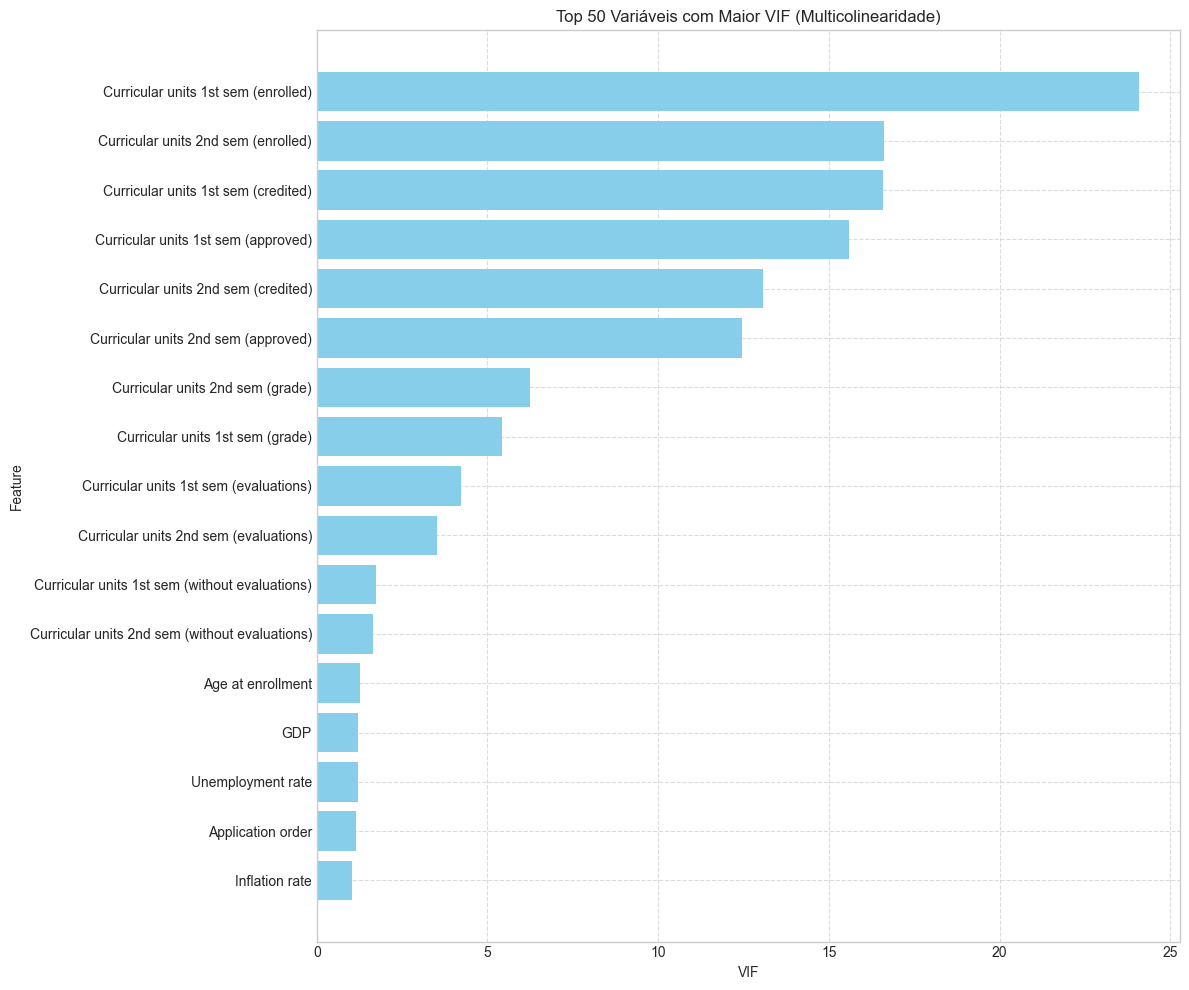

In [12]:
# X_dum = pd.get_dummies(df, drop_first=True)
# X_dum = X_dum.astype(float)
# X_const = add_constant(X_dum)

X_numeric = df.select_dtypes(include=np.number).dropna()
X_const = add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

top_vif = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False).head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_vif["feature"], top_vif["VIF"], color="skyblue")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Top 50 Vari√°veis com Maior VIF (Multicolinearidade)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Interpreta√ß√£o dos Valores de VIF

- $VIF = 1$ : Sem multicolinearidade 
- $1 < VIF < 5$ : Baixa multicolinearidade 
- $5 < VIF < 10$ : Moderada multicolinearidade (aten√ß√£o)
- $VIF > 10$ : Alta multicolinearidade (problem√°tico)

Um valor alto de VIF √© problem√°tico por v√°rias raz√µes. Primeiro, ele indica coeficientes inst√°veis, pois o modelo tem dificuldade em distinguir os efeitos individuais das vari√°veis correlacionadas. Al√©m disso, h√° redund√¢ncia, j√° que a vari√°vel com VIF alto geralmente n√£o adiciona nova informa√ß√£o, podendo ser prevista pelas demais. Isso tamb√©m pode levar a overfitting, pois o modelo se ajusta em excesso aos dados de treino ao incorporar vari√°veis que n√£o contribuem efetivamente para a explica√ß√£o da vari√°vel alvo. Por fim, h√° uma dificuldade de interpreta√ß√£o, j√° que se torna confuso identificar qual vari√°vel est√° realmente impactando a resposta.


- **VIF Extremamente Alto (> 10)**: As vari√°veis Curricular units 1st/2nd sem (enrolled), (credited) e (approved) apresentam VIFs alt√≠ssimos, chegando a 24.08. Isso significa que mais de 95% da vari√¢ncia de Curricular units 1st sem (enrolled) pode ser explicada pelas outras vari√°veis num√©ricas.
- **VIF Alto (> 5)**: As vari√°veis de notas (grade) tamb√©m mostram um VIF elevado.

**Insight Principal**: Isso √© totalmente esperado e l√≥gico. O n√∫mero de mat√©rias em que um aluno se matricula (enrolled), o n√∫mero de mat√©rias que ele valida (credited) e o n√∫mero que ele passa (approved) est√£o intrinsecamente ligados. S√£o diferentes medidas do mesmo conceito fundamental: o volume e o sucesso acad√™mico do aluno em um semestre.

A alta multicolinearidade no bloco acad√™mico pode ser um problema, especialmente para modelos lineares (como Regress√£o Log√≠stica), pois torna os coeficientes do modelo inst√°veis e dif√≠ceis de interpretar.

##### Poss√≠veis Estrat√©gias

- Remo√ß√£o cuidadosa das features com VIF alto;
- Feature Engineering: combinar as vari√°veis correlacionadas para criar novas features mais poderosas e que resolvam a multicolinearidade.
- Usar modelos naturalmente mais robustos √† multicolinearidade, como Random Forest, LightGBM, XGBoost, e outrosbaseados em ensemble.

### An√°lise de Assimetria (Skewness) e Detec√ß√£o de Outliers


A assimetria mede o grau de distor√ß√£o da distribui√ß√£o de uma vari√°vel em rela√ß√£o a uma distribui√ß√£o sim√©trica (curva de sino). Outliers s√£o pontos de dados que se desviam drasticamente dos demais.

Por que usar?

- Alguns modelos como Regress√£o Linear e SVMs funcionam melhor com dados que t√™m uma distribui√ß√£o pr√≥xima da normal (baixa assimetria).

- Identificar outliers nos ajuda a entender se s√£o erros de digita√ß√£o que precisam ser corrigidos ou se s√£o casos extremos e leg√≠timos que cont√™m informa√ß√µes importantes sobre o comportamento dos alunos.


--- Gr√°ficos de Densidade de Kernel (KDE) ---


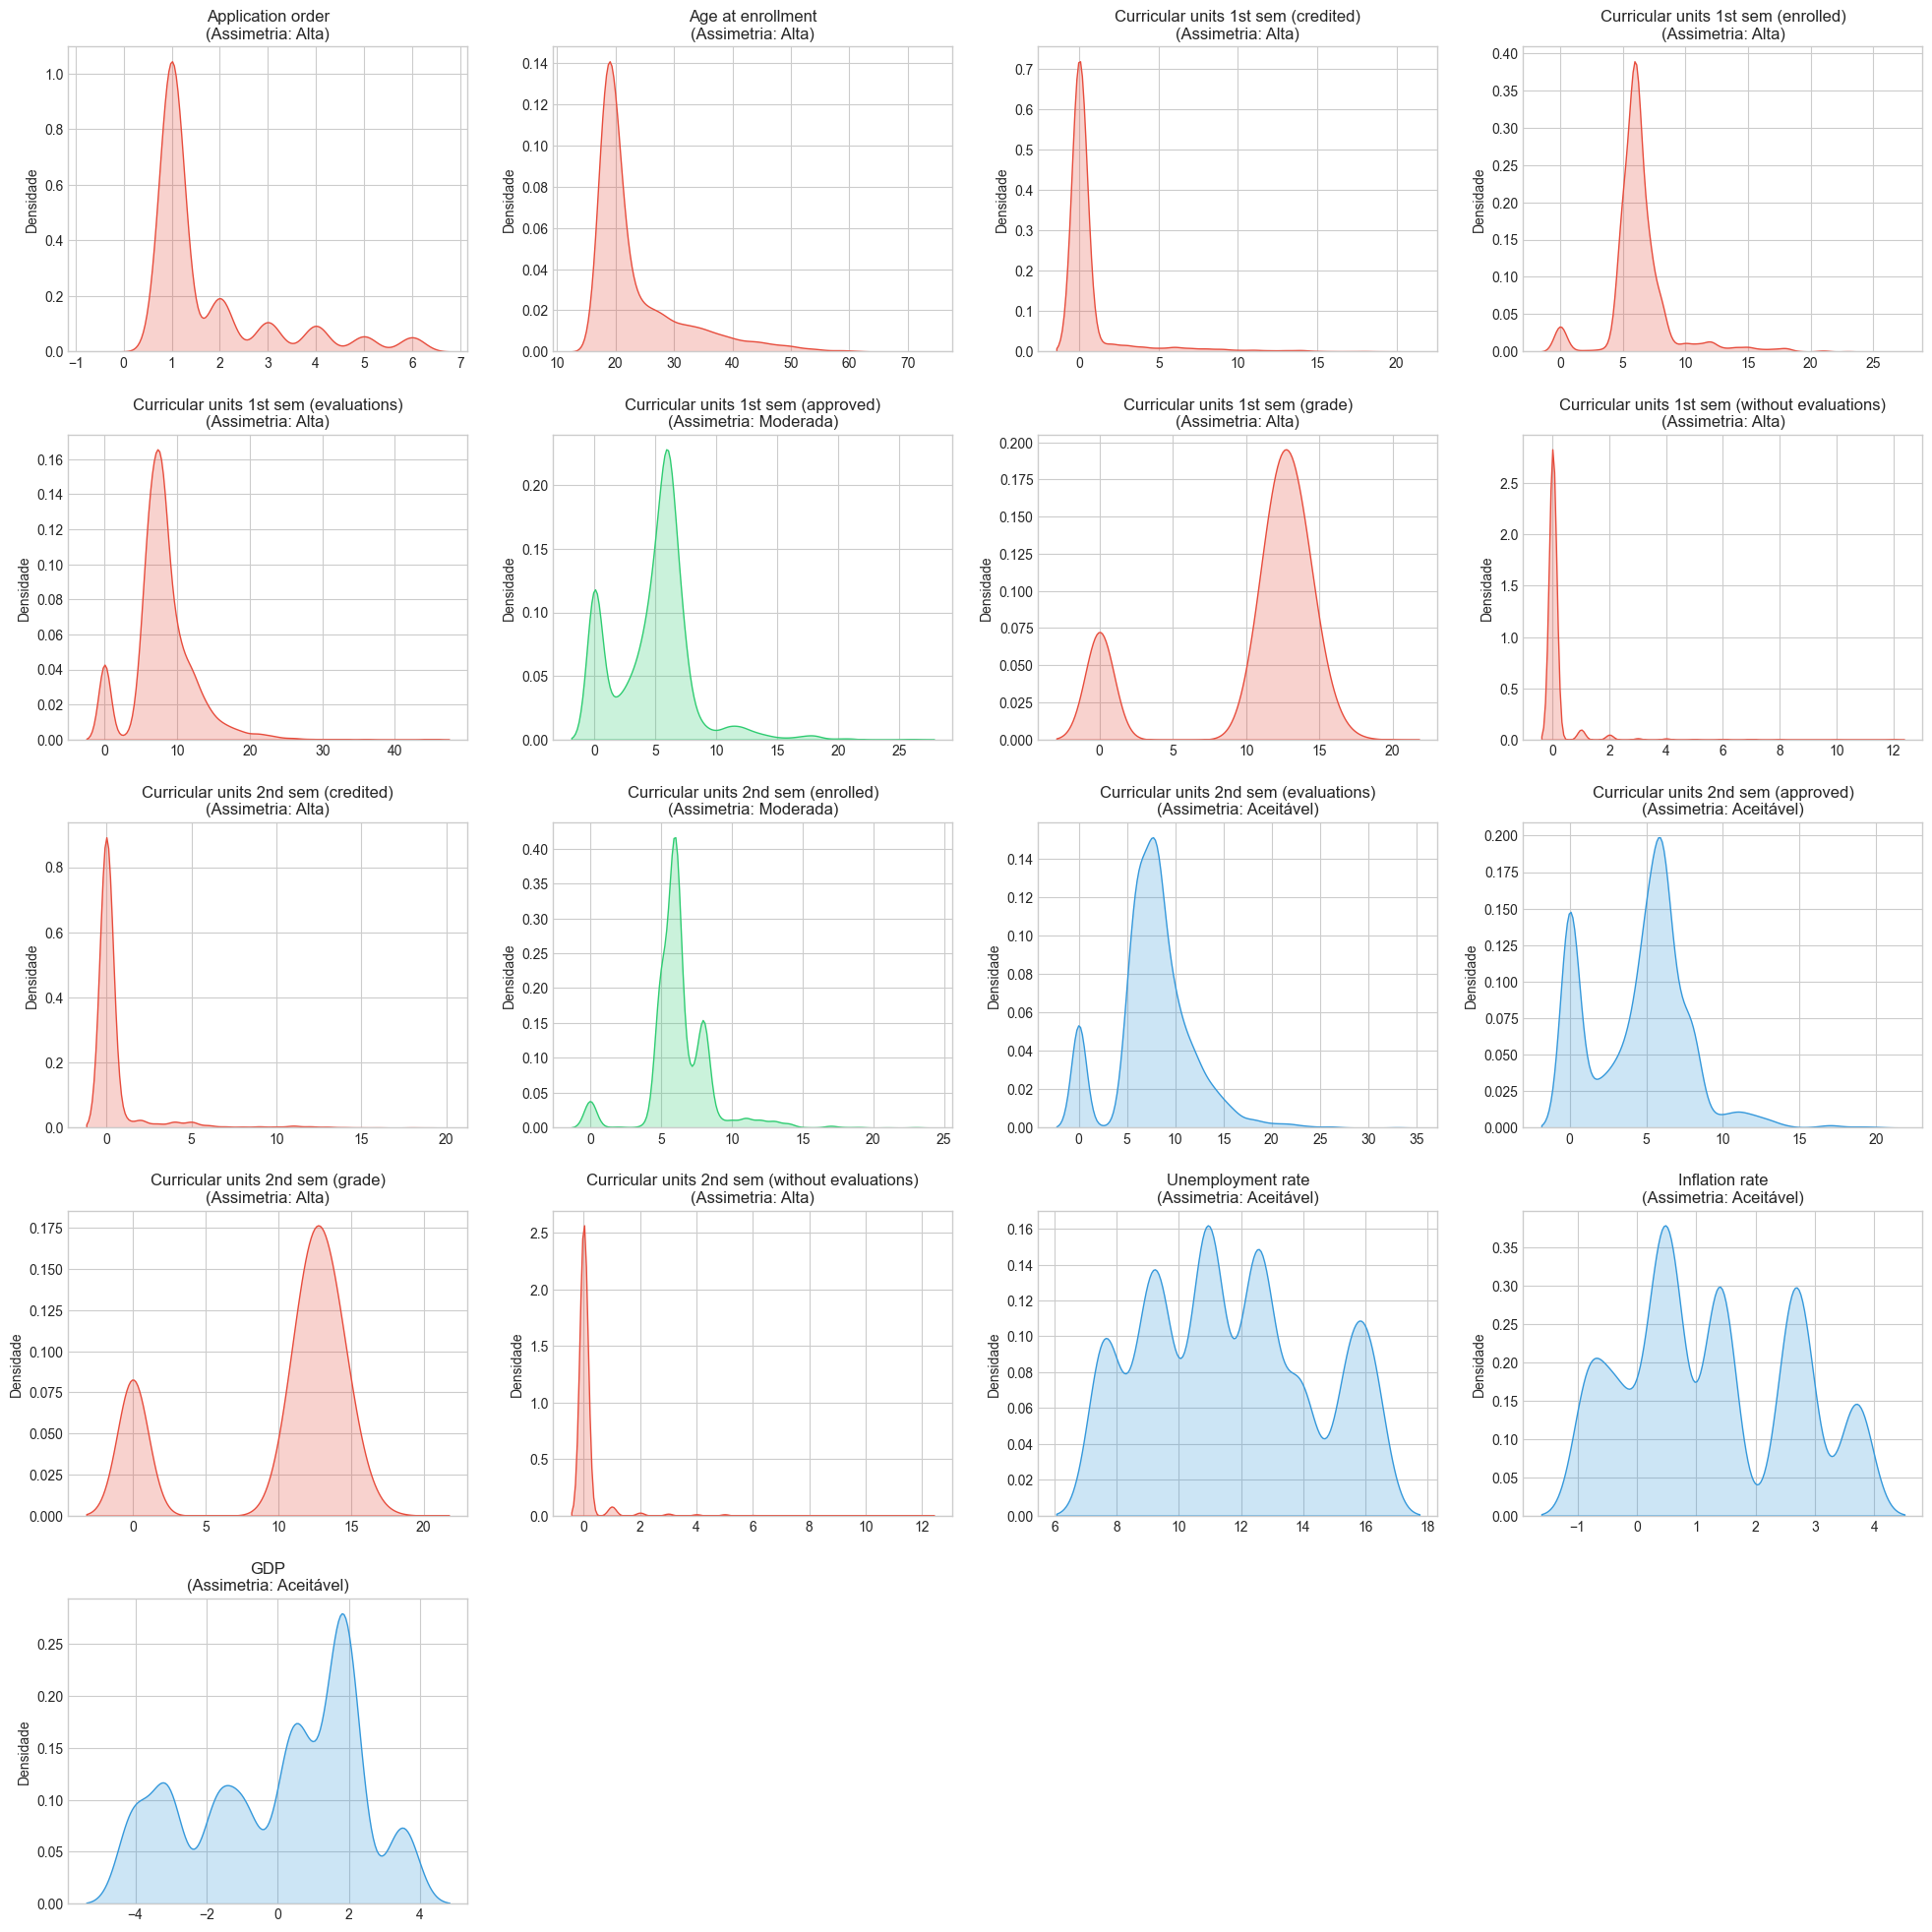

Skewness Tipo de Assimetria
Curricular units 1st sem (without evaluations)  8.719276               Alta
Curricular units 2nd sem (without evaluations)  7.615448               Alta
Curricular units 2nd sem (credited)             4.494329               Alta
Curricular units 1st sem (credited)             4.064552               Alta
Age at enrollment                               1.990725               Alta
Application order                               1.817973               Alta
Curricular units 1st sem (enrolled)             1.651648               Alta
Curricular units 1st sem (grade)               -1.451853               Alta
Curricular units 2nd sem (grade)               -1.167812               Alta
Curricular units 1st sem (evaluations)          1.146086               Alta
Curricular units 2nd sem (enrolled)             0.811620           Moderada
Curricular units 1st sem (approved)             0.754178           Moderada
GDP                                            -0.390805          Aceit√°vel
Curricular units 2nd sem (evaluations)          0.378069          Aceit√°vel
Curricular units 2nd sem (approved)             0.268199          Aceit√°vel
Inflation rate                                  0.267055          Aceit√°vel
Unemployment rate                               0.189502          Aceit√°vel

In [13]:
numerical_features = df.select_dtypes(include=np.number)

skewness = numerical_features.skew()
skew_df = pd.DataFrame(skewness, columns=['Skewness']) 

skew_df['Tipo de Assimetria'] = skew_df['Skewness'].apply(
    lambda x: 'Alta' if abs(x) > 1 else 'Moderada' if abs(x) >= 0.5 else 'Aceit√°vel'
)

color_map = {
    'Alta': '#E74C3C',
    'Moderada': '#2ECC71',
    'Aceit√°vel': '#3498DB'
}

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

print("\n--- Gr√°ficos de Densidade de Kernel (KDE) ---")
for i, col in enumerate(numerical_features.columns):
    tipo_assimetria = skew_df.loc[col, 'Tipo de Assimetria']
    plot_color = color_map[tipo_assimetria]

    sns.kdeplot(ax=axes[i], data=df, x=col, fill=True, color=plot_color)
    
    axes[i].set_title(f'{col}\n(Assimetria: {tipo_assimetria})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Densidade')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

skew_df_sorted = skew_df.sort_values(by='Skewness', key=abs, ascending=False)
display(skew_df_sorted)

- As vari√°veis com a maior assimetria positiva, de longe, s√£o `Curricular units (without evaluations)` e `Curricular units (credited)`. Isso indica um comportamento de "tudo ou nada". A grande maioria dos alunos tem um valor de zero para essas vari√°veis (ou seja, participam de todas as avalia√ß√µes e n√£o t√™m cr√©ditos anteriores para validar). No entanto, uma pequena minoria de alunos se desvia desse padr√£o (n√£o comparece a avalia√ß√µes ou vem de transfer√™ncias com muitos cr√©ditos), criando uma "cauda" longa e positiva na distribui√ß√£o. Essas n√£o s√£o apenas vari√°veis, s√£o fortes indicadores de perfis de alunos distintos: o aluno desengajado e o aluno transferido.

- As √∫nicas vari√°veis com assimetria negativa significativa s√£o as notas (grade) do 1¬∫ e 2¬∫ semestres. Isso √© causado por um "efeito teto". A escala de notas tem um valor m√°ximo (ex: 20). A maioria dos alunos que permanecem no curso e s√£o aprovados tende a ter um bom desempenho, com as notas se concentrando na parte superior da escala. Um n√∫mero menor de alunos tem um desempenho muito ruim, o que "puxa" a cauda da distribui√ß√£o para a esquerda (em dire√ß√£o √† nota zero). Isso sugere que notas muito baixas s√£o a exce√ß√£o, n√£o a regra.

Para as vari√°veis com assimetria Alta (tanto positiva quanto negativa), √© altamente recomend√°vel aplicar uma transforma√ß√£o (como a logar√≠tmica, `np.log1p`) antes de treinar modelos sens√≠veis √† escala, como Regress√£o Log√≠stica, SVM, Naive Bayes ou Redes Neurais. Isso ajuda o modelo a funcionar melhor.



--- Detec√ß√£o Visual de Outliers ---


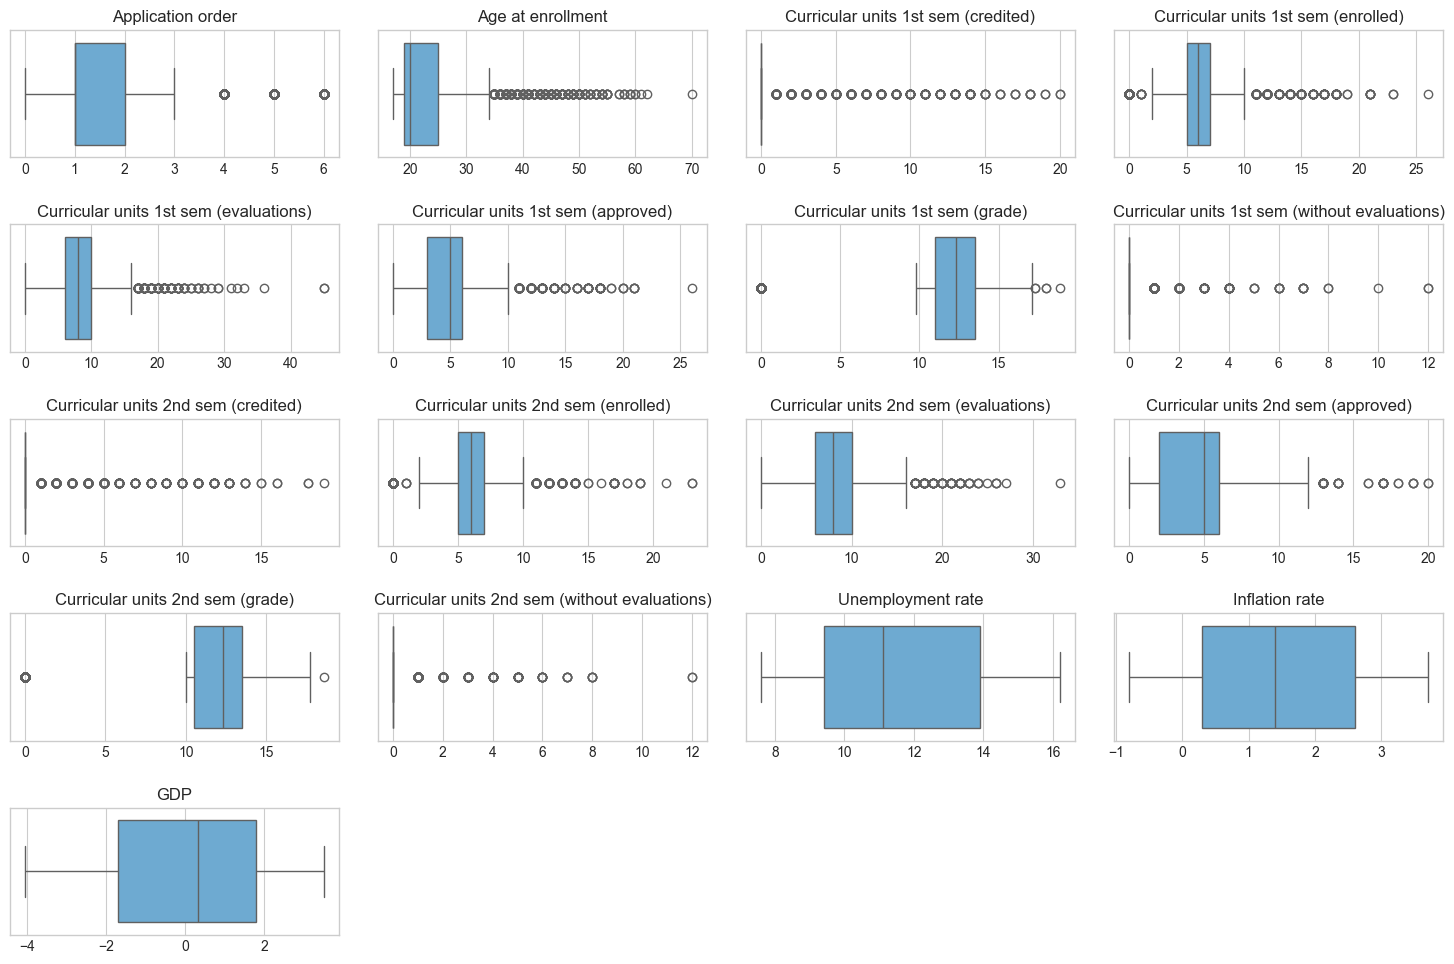

In [14]:
print("\n\n--- Detec√ß√£o Visual de Outliers ---")

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))
axes = axes.flatten()
    
for i, col in enumerate(numerical_features.columns):
    sns.boxplot(ax=axes[i], x=numerical_features[col], color='#5DADE2')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

- **Age at enrollment (Idade de Ingresso)**: O box plot mostra claramente uma concentra√ß√£o de alunos na faixa et√°ria tradicional (18-22 anos). Os in√∫meros pontos de outlier √† direita, indo at√© os 70 anos, s√£o os alunos maduros ("mature students"). Eles s√£o um grupo demogr√°fico distinto e fundamental para a an√°lise, n√£o um erro.

- **Curricular units ... (credited) (Unidades Creditadas)**: O "box" est√° achatado no zero, o que significa que a maioria dos alunos n√£o valida nenhuma mat√©ria. Todos os pontos de outlier s√£o, na verdade, os alunos transferidos ou com qualifica√ß√µes anteriores.

- **Curricular units ... (without evaluations) (Unidades sem Avalia√ß√£o)**: Este √© talvez o insight mais cr√≠tico. O box tamb√©m est√° achatado no zero, indicando que o comportamento normal √© participar de todas as avalia√ß√µes. Os outliers, portanto, s√£o os alunos desengajados. Cada ponto aqui √© um forte sinal de alerta de evas√£o.

- **Curricular units ... (grade) (Notas)**: Os outliers aqui est√£o principalmente na extremidade inferior. Enquanto a maioria dos alunos se concentra em notas mais altas (o "box"), os outliers de nota baixa representam os alunos com grande dificuldade acad√™mica, que s√£o os mais propensos a evadir.

- **Curricular units ... (approved) (Unidades Aprovadas)**: Os outliers na extremidade superior representam os alunos de alt√≠ssimo desempenho, que conseguem ser aprovados em um n√∫mero de mat√©rias bem acima da m√©dia.

- **Dados Macroecon√¥micos (Unemployment rate, Inflation rate, GDP)**: Como esperado, essas vari√°veis mostram distribui√ß√µes muito mais sim√©tricas e com poucos ou nenhum outlier. Isso ocorre porque s√£o dados agregados de uma economia, n√£o refletindo comportamentos individuais extremos.

##### Conclus√£o

N√£o deve ser removido nenhum outlier. Remover esses pontos significaria apagar a informa√ß√£o sobre os perfis mais importantes para um modelo preditivo: os alunos maduros, os transferidos, os desengajados e os com desempenho muito baixo. Isso prejudicaria drasticamente a capacidade do modelo de prever a evas√£o.

In [15]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

## Feature Engineering

A etapa de Engenharia de Features √© onde os insights da nossa an√°lise explorat√≥ria e estat√≠stica √© usada para transformar os dados brutos em "sinais" muito mais claros e enriquecidos para o um modelo preditivo. Quanto melhor q qualidade das features, melhor o modelo.

Modelos matem√°ticos n√£o entendem texto solto (como 'Dropout' ou 'Graduate'). √â preciso convert√™-los em n√∫meros, e a melhor abordagem depende da natureza de cada vari√°vel. Por isso, usamos uma estrat√©gia h√≠brida baseada na cardinalidade (o n√∫mero de categorias √∫nicas):

| Caracter√≠stica         | One-Hot Encoding (`OneHotEncoder`)                                                                            | Target Encoding (`TargetEncoder`)                                                                                             |
|:-----------------------|:--------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------|
| **O que faz?** | Cria uma nova coluna bin√°ria (0 ou 1) para **cada categoria** da vari√°vel original.                               | Substitui cada categoria por um **√∫nico n√∫mero**: a m√©dia do alvo (`Target`) para aquela categoria.                             |
| **Quando Usar?** | Vari√°veis com **baixa cardinalidade** (poucas categorias √∫nicas, ex: 2 a 5). <br> *Ex: `Gender`, `Displaced`.* | Vari√°veis com **alta cardinalidade** (muitas categorias √∫nicas, ex: 6 ou mais). <br> *Ex: `Course`, `Mother's occupation`.* |
| **Vantagem Principal** | Representa√ß√£o completa e "honesta" dos dados, sem assumir rela√ß√µes de ordem ou valor entre as categorias.       | Extremamente eficiente. Captura o poder preditivo em uma √∫nica coluna, evitando a "maldi√ß√£o da dimensionalidade".            |
| **Desvantagem Principal**| Invi√°vel para alta cardinalidade (cria colunas demais, ex: 30 cursos -> 29 novas colunas).                     | Maior risco de overfitting. Requer t√©cnicas cuidadosas (como a valida√ß√£o cruzada) para ser robusto.   |
| **Exemplo Pr√°tico** | A coluna `Gender` com valores 'Male' e 'Female' se transforma na coluna `Gender_Male` com valores 0 ou 1.     | A categoria `'Enfermagem'` na coluna `Course` √© substitu√≠da pelo valor `0.18` (se a taxa de evas√£o em Enfermagem for 18%). |

In [16]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_weak_features=True, rare_threshold=0.01):
        self.drop_weak_features = drop_weak_features
        self.rare_threshold = rare_threshold

    def fit(self, X, y):
        if not isinstance(y, pd.Series):
            y = pd.Series(y, name='Target')
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not is_numeric_dtype(y) or y.dtype.name == 'category':
            if y.unique().tolist() == ['Graduate', 'Dropout'] or 'Dropout' in y.unique().tolist():
                y = y.apply(lambda x: 1 if x == 'Dropout' else 0).rename('Target')
            else:
                y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int) 

        self.course_grade_map_1sem_ = X.groupby('Course', observed=False)['Curricular units 1st sem (grade)'].mean()
        self.course_grade_map_2sem_ = X.groupby('Course', observed=False)['Curricular units 2nd sem (grade)'].mean()
        self.global_grade_mean_1sem_ = X['Curricular units 1st sem (grade)'].mean()
        self.global_grade_mean_2sem_ = X['Curricular units 2nd sem (grade)'].mean()

        original_categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.ohe_cols_ = [col for col in original_categorical_cols if X[col].nunique() <= 5]
        self.target_cols_ = [col for col in original_categorical_cols if X[col].nunique() > 5]
        
        self.target_cols_.append('interacao_curso_genero')
        self.ohe_cols_.append('faixa_etaria')

        # L√≥gica para aprender quais categorias s√£o raras em TODAS as colunas categ√≥ricas originais
        self.rare_maps_ = {}
        # As qualifica√ß√µes dos pais s√£o tratadas numericamente, ent√£o as exclu√≠mos deste passo.
        cols_to_check_for_rares = [col for col in original_categorical_cols if col not in ["Mother's qualification", "Father's qualification"]]
        for col in cols_to_check_for_rares:
            counts = X[col].value_counts(normalize=True)
            rare_cats = counts[counts < self.rare_threshold].index.tolist()
            if rare_cats:
                self.rare_maps_[col] = rare_cats

        X_temp_for_fit = X.copy()
        for col, rare_list in self.rare_maps_.items():
            X_temp_for_fit[col] = X_temp_for_fit[col].astype(str).replace(rare_list, 'Other')
        
        X_temp_for_fit['interacao_curso_genero'] = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
        X_temp_for_fit['faixa_etaria'] = pd.cut(X_temp_for_fit['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False)

        for col in self.target_cols_ + self.ohe_cols_:
             if col in X_temp_for_fit.columns:
                X_temp_for_fit[col] = X_temp_for_fit[col].astype(str)
        
        self.target_maps_ = {}
        self.global_mean_ = y.mean()
        for col in self.target_cols_:
            if col == 'interacao_curso_genero':
                interaction_series = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
                self.target_maps_[col] = pd.concat([interaction_series.rename(col), y], axis=1).groupby(col, observed=False)[y.name].mean()
            else:
                self.target_maps_[col] = pd.concat([X_temp_for_fit[col], y], axis=1).groupby(col, observed=False)[y.name].mean()
        
        self.target_encoder_ = TargetEncoder(target_type='binary')
        self.target_encoder_.fit(X_temp_for_fit[self.target_cols_], y)

        self.ohe_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
        self.ohe_.fit(X_temp_for_fit[self.ohe_cols_])
        
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed['nivel_educacional_pais'] = (X_transformed["Mother's qualification"].astype(int) + X_transformed["Father's qualification"].astype(int))
        X_transformed['indice_estresse_financeiro'] = (X_transformed['Debtor'].astype(int) - X_transformed['Scholarship holder'].astype(int) + (1 - X_transformed['Tuition fees up to date'].astype(int)))

        for col, rare_list in self.rare_maps_.items():
            X_transformed[col] = X_transformed[col].astype(str).replace(rare_list, 'Other')

        X_transformed['interacao_curso_genero'] = X_transformed['Course'].astype(str) + '_' + X_transformed['Gender'].astype(str)
        X_transformed['faixa_etaria'] = pd.cut(X_transformed['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False).astype(str)
        
        if hasattr(self, 'course_grade_map_1sem_'):
            avg_grade_1sem = X_transformed['Course'].astype(str).map(self.course_grade_map_1sem_).fillna(self.global_grade_mean_1sem_)
            X_transformed['desvio_nota_1sem'] = X_transformed['Curricular units 1st sem (grade)'] - avg_grade_1sem
            avg_grade_2sem = X_transformed['Course'].astype(str).map(self.course_grade_map_2sem_).fillna(self.global_grade_mean_2sem_)
            X_transformed['desvio_nota_2sem'] = X_transformed['Curricular units 2nd sem (grade)'] - avg_grade_2sem

        X_transformed['taxa_aprovacao_1sem'] = (X_transformed['Curricular units 1st sem (approved)'] / X_transformed['Curricular units 1st sem (enrolled)']).fillna(0)
        X_transformed['taxa_aprovacao_2sem'] = (X_transformed['Curricular units 2nd sem (approved)'] / X_transformed['Curricular units 2nd sem (enrolled)']).fillna(0)
        X_transformed['progresso_academico'] = X_transformed['taxa_aprovacao_2sem'] - X_transformed['taxa_aprovacao_1sem']
        total_without_evals = X_transformed['Curricular units 1st sem (without evaluations)'] + X_transformed['Curricular units 2nd sem (without evaluations)']
        X_transformed['aluno_desengajado'] = (total_without_evals > 0).astype(int)

        for col in self.target_cols_ + self.ohe_cols_:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype(str)
                
        target_encoded_data = self.target_encoder_.transform(X_transformed[self.target_cols_])
        target_encoded_df = pd.DataFrame(target_encoded_data, index=X_transformed.index, columns=[f"{c}_encoded" for c in self.target_cols_])

        ohe_data = self.ohe_.transform(X_transformed[self.ohe_cols_])
        ohe_df = pd.DataFrame(ohe_data, index=X_transformed.index, columns=self.ohe_.get_feature_names_out(self.ohe_cols_))
        
        X_final = X_transformed
        X_final = pd.concat([X_final, target_encoded_df, ohe_df], axis=1)

        cols_to_drop = [
            # Categ√≥ricas substitu√≠das por encoders
            'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 
            'Previous qualification', 'Nacionality', "Mother's occupation", 
            "Father's occupation", 'Displaced', 'Educational special needs', 'Gender', 'International',
            # Num√©ricas substitu√≠das por features de engenharia
            'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (grade)',
            'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (grade)',
            'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)',
            'Debtor', 'Tuition fees up to date', 'Scholarship holder', 
            "Mother's qualification", "Father's qualification", 'Age at enrollment'
        ]
        
        X_final = X_final.drop(columns=cols_to_drop, errors='ignore')
        X_final = X_final.drop(columns=['interacao_curso_genero', 'faixa_etaria'], errors='ignore')

        if self.drop_weak_features:
            weak_features = [col for col in X_final.columns if 'International' in col or 'Educational special needs' in col]
            X_final = X_final.drop(columns=weak_features, errors='ignore')
            
        return X_final

O resultado √© um dataset completamente num√©rico e enriquecido, pronto para ser utilizado pelos algoritmos de Machine Learning.

Features Codificadas:
- As colunas terminadas em `_encoded` (ex: `Course_encoded`) cont√™m os valores do Target Encoding. Cada valor representa a taxa m√©dia de evas√£o associada √† categoria original, medindo efetivamente o "risco" de cada uma.
- As colunas terminadas com o nome da categoria (ex: `faixa_etaria_Maduro`) s√£o o resultado do One-Hot Encoding. Elas s√£o "flags" bin√°rias (0 ou 1) que indicam a presen√ßa ou aus√™ncia de uma determinada caracter√≠stica.


Features Originais Mantidas: Vari√°veis num√©ricas que n√£o apresentaram alta multicolinearidade e n√£o foram substitu√≠das por features de engenharia (como Application order e os indicadores macroecon√¥micos) foram mantidas em sua forma original.

- **Para Reduzir Multicolinearidade (Insight do VIF e Correla√ß√£o)**: Vimos que as `Curricular units ...` eram altamente correlacionadas. Em vez de us√°-las diretamente, criamos taxas como `taxa_aprovacao_ ...` (aprovadas / matriculadas), que s√£o mais informativas e resolvem a redund√¢ncia.

- **Para Capturar Comportamentos (Insight da Assimetria e Outliers)**: A an√°lise mostrou que `Curricular units (without evaluations)` indicava um comportamento de "tudo ou nada". A feature `aluno_desengajado` transforma essa observa√ß√£o estat√≠stica em uma "flag" de risco clara e direta para o modelo.

- **Para Combinar Preditores Fortes (Insight do Qui-Quadrado e ANOVA)**: Nossa an√°lise mostrou que `Debtor`, `Tuition fees up to date` e `Scholarship holder` eram os preditores mais fortes. A feature `indice_estresse_financeiro` os combina em um √∫nico e poderoso indicador da situa√ß√£o do aluno.

√â importante notar que todo o "aprendizado" necess√°rio para as transforma√ß√µes (como as m√©dias para o Target Encoding e as categorias para o One-Hot Encoding) devem ser feitos apenas com os dados de treino e teste de forma separada. Isso garante que n√£o haja vazamento de dados (data leakage).

# Model Selection

In [17]:
X = df.drop('Target', axis=1)
y = df['Target'].map({'Dropout': 1, 'Graduate': 0})
y.name = 'Target'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

## MLP e Naive Bayes (Analise Focada)

In [18]:
class ReflectionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_values_ = None

    def fit(self, X, y=None):
        # Aprende o valor m√°ximo de cada coluna nos dados de treino
        self.max_values_ = X.max()
        return self

    def transform(self, X):
        # Aplica a f√≥rmula de reflex√£o: (max + 1) - valor
        return (self.max_values_ + 1) - X


In [19]:


class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """
    Recebe um dataframe com features j√° criadas, analisa suas
    distribui√ß√µes (assimetria) e aplica o pr√©-processamento correto
    (log, reflex√£o, escalonamento) a cada subconjunto de colunas.
    Isso ajuda a normalizar a distribui√ß√£o de features, sendo extremamente
    importante para modelos como o Gaussian Naive Bayes, que parte da premissa
    de normalidade dos dados para treinamento.
    """
    def __init__(self, positive_skew_threshold=1.0, negative_skew_threshold=-1.0):
        self.positive_skew_threshold = positive_skew_threshold
        self.negative_skew_threshold = negative_skew_threshold

    def fit(self, X, y=None):
        skewness = X.skew(numeric_only=False)
        
        self.positive_skew_features_ = skewness[skewness > self.positive_skew_threshold].index.tolist()
        self.negative_skew_features_ = skewness[skewness < self.negative_skew_threshold].index.tolist()
        
        all_numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        ohe_cols = [col for col in X.columns if '_' in col and X[col].nunique() <= 2]
        passthrough_features = ohe_cols + [col for col in X.columns if 'aluno_desengajado' in col]

        self.numeric_no_skew_features_ = [
            col for col in all_numeric_cols 
            if col not in self.positive_skew_features_ and col not in self.negative_skew_features_ and col not in passthrough_features
        ]

        self.preprocessor_ = ColumnTransformer(
            transformers=[
                ('pos_skew', SklearnPipeline(
                    steps=[
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.positive_skew_features_),
                ('neg_skew', SklearnPipeline(
                    steps=[
                        ('reflect', ReflectionTransformer()), 
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.negative_skew_features_),
                ('no_skew', StandardScaler(), self.numeric_no_skew_features_)
            ],
            remainder='passthrough'
        )
        
        self.preprocessor_.fit(X)
        return self

    def transform(self, X):
        return self.preprocessor_.transform(X)

In [20]:
models_with_class_weight = {
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, activation='relu', solver='adam', batch_size=64),
    "Naive Bayes": GaussianNB(),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_predictions_df = pd.DataFrame({'y_real': y_train.copy()})
f1_scores = {}

for name, model in models_with_class_weight.items():
    full_pipeline = SklearnPipeline(
        steps=[
            ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
            ('dynamic_preprocessor', DynamicPreprocessor()),
            ('classifier', model)
        ]
    )
    
    print(f"Processando: {name}...")

    predictions = cross_val_predict(full_pipeline, X_train, y_train, cv=cv_strategy)
    cv_predictions_df[name] = predictions
    
    f1 = cross_val_score(
        estimator=full_pipeline,
        X=X_train,
        y=y_train,
        cv=cv_strategy,
        scoring=make_scorer(
            f1_score
        ),
        n_jobs=-1
    )
    
    f1_scores[name] = (np.mean(f1), np.std(f1))

    print(f"\n--- Resultados da Valida√ß√£o Cruzada modelo {name}---")
    print(f"F1 Score M√©dio: {f1_scores[name][0]:.4f}")
    print(f"Desvio Padr√£o dos Scores: {f1_scores[name][1]:.4f}")

Processando: MLP...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



--- Resultados da Valida√ß√£o Cruzada modelo MLP---
F1 Score M√©dio: 0.8732
Desvio Padr√£o dos Scores: 0.0155
Processando: Naive Bayes...

--- Resultados da Valida√ß√£o Cruzada modelo Naive Bayes---
F1 Score M√©dio: 0.8137
Desvio Padr√£o dos Scores: 0.0260


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Tunagem de Hyperparametros

Para maximizar a capacidade preditiva dos modelos de classifica√ß√£o, foi conduzido um processo de otimiza√ß√£o de hiperpar√¢metros. O objetivo foi encontrar a combina√ß√£o de par√¢metros que maximizasse a performance de cada algoritmo, utilizando o F1-Score da classe minorit√°ria (`Dropout`) como m√©trica principal de avalia√ß√£o, por ser robusta a datasets desbalanceados.

A t√©cnica de otimiza√ß√£o empregada foi a Busca Bayesiana, implementada atrav√©s da classe BayesSearchCV da biblioteca scikit-optimize. Esta abordagem √© mais eficiente que buscas exaustivas, pois utiliza os resultados de itera√ß√µes passadas para explorar de forma inteligente o espa√ßo de busca. Para cada modelo, foram realizadas 80 itera√ß√µes.

A performance de cada combina√ß√£o de hiperpar√¢metros foi avaliada utilizando uma estrat√©gia de valida√ß√£o cruzada estratificada com 5 folds (StratifiedKFold), garantindo que a propor√ß√£o de classes fosse mantida em cada divis√£o dos dados de treino.

Para o modelo **MLP**, a arquitetura da rede foi mantida fixa para focar a otimiza√ß√£o nos par√¢metros de treinamento, com duas camadas ocultas de 100 e 50 neur√¥nios, respectivamente. Os demais par√¢metros foram configurados da seguinte forma:

- Otimizador (`solver`): adam, um otimizador eficiente baseado em gradiente estoc√°stico.
- M√°ximo de √âpocas (`max_iter`): 500.
- Parada Antecipada (`early_stopping`): Ativada (True) para prevenir overfitting, reservando uma por√ß√£o dos dados de treino de cada fold para valida√ß√£o interna.

O espa√ßo de busca para os hiperpar√¢metros otimizados foi:

- Fun√ß√£o de Ativa√ß√£o (`activation`): relu e tanh.
- Par√¢metro de Regulariza√ß√£o Alpha (`alpha`): Escala log-uniforme entre 1e-5 e 1e-1.
- Taxa de Aprendizagem Inicial (`learning_rate_init`): Escala log-uniforme entre 1e-4 e 1e-2.
- Tamanho do Lote (`batch_size`): Valores inteiros entre 8 e 128.

Diferente do MLP, o modelo **Gaussian Naive Bayes** possui menos hiperpar√¢metros. A otimiza√ß√£o focou no par√¢metro de suaviza√ß√£o de vari√¢ncia, que √© crucial para a estabilidade num√©rica do algoritmo.

O espa√ßo de busca para o hiperpar√¢metro otimizado foi:

- Suaviza√ß√£o de Vari√¢ncia (`var_smoothing`): Escala log-uniforme entre 1e-10 e 1e-3.

In [21]:
search_space_mlp = {
    'classifier__activation': Categorical(['relu', 'tanh']),
    'classifier__alpha': Real(1e-5, 1e-1, 'log-uniform'),
    'classifier__learning_rate_init': Real(1e-4, 1e-2, 'log-uniform'),
    'classifier__batch_size': Integer(8, 128)
}

search_space_nb = {
    'classifier__var_smoothing': Real(1e-10, 1e-3, 'log-uniform'),
}

models_to_optimize = {
    "MLP": (MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, solver='adam'), search_space_mlp),
    "Naive Bayes": (GaussianNB(), search_space_nb),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_estimators = {}

print(f"--- Iniciando Otimiza√ß√£o Bayesiana ---")
for name, (model, search_space) in models_to_optimize.items():
    
    full_pipeline = SklearnPipeline(steps=[
        ('feature_engineser', FeatureEngineer(drop_weak_features=True)),
        ('dynamic_preprocessor', DynamicPreprocessor()),
        ('classifier', model)
    ])

    # Configura√ß√£o da Busca Bayesiana
    optimizer = BayesSearchCV(
        estimator=full_pipeline,
        search_spaces=search_space,
        n_iter=80,
        cv=cv_strategy,
        scoring=make_scorer(
            f1_score
        ),
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    print(f"\nOtimizando o modelo: {name}...")
    optimizer.fit(X_train, y_train)
    
    best_estimators[name] = optimizer.best_estimator_
    
    print("Otimiza√ß√£o conclu√≠da.")
    print(f"Melhor F1-Score (cross-val): {optimizer.best_score_:.4f}")
    print("Melhores Hiperpar√¢metros encontrados:")
    print(optimizer.best_params_)

--- Iniciando Otimiza√ß√£o Bayesiana ---

Otimizando o modelo: MLP...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown c

Otimiza√ß√£o conclu√≠da.
Melhor F1-Score (cross-val): 0.8777
Melhores Hiperpar√¢metros encontrados:
OrderedDict({'classifier__activation': 'tanh', 'classifier__alpha': 1e-05, 'classifier__batch_size': 8, 'classifier__learning_rate_init': 0.0003200100030459876})

Otimizando o modelo: Naive Bayes...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown c

Otimiza√ß√£o conclu√≠da.
Melhor F1-Score (cross-val): 0.8137
Melhores Hiperpar√¢metros encontrados:
OrderedDict({'classifier__var_smoothing': 7.425534359037021e-08})


#### Resultados

**MLP**: Ap√≥s a otimiza√ß√£o, o MLP alcan√ßou um F1-Score m√©dio de 0.8777. A melhor combina√ß√£o de par√¢metros encontrada foi:
- `activation`: `'tanh'`
- `alpha`: `1e-05`
- `batch_size`: `8`
- `learning_rate_init`: `0.00032`

**Naive Bayes**: A otimiza√ß√£o resultou em um F1-Score m√©dio de 0.8137. O melhor valor encontrado para o par√¢metro foi:
- `var_smoothing`: `7.42e-08`

In [22]:
from sklearn import set_config
set_config(display='diagram')

for name, pipeline in best_estimators.items():
    display(best_estimators[name])

Pipeline(steps=[('feature_engineser', FeatureEngineer()),
                ('dynamic_preprocessor', DynamicPreprocessor()),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=1e-05, batch_size=8,
                               early_stopping=True,
                               hidden_layer_sizes=(100, 50),
                               learning_rate_init=0.0003200100030459876,
                               max_iter=500, random_state=42))])

Pipeline(steps=[('feature_engineser', FeatureEngineer()),
                ('dynamic_preprocessor', DynamicPreprocessor()),
                ('classifier',
                 GaussianNB(var_smoothing=7.425534359037021e-08))])

### Compara√ß√£o das M√©tricas Finais 

Avaliando o melhor modelo: MLP...
Avaliando o melhor modelo: Naive Bayes...


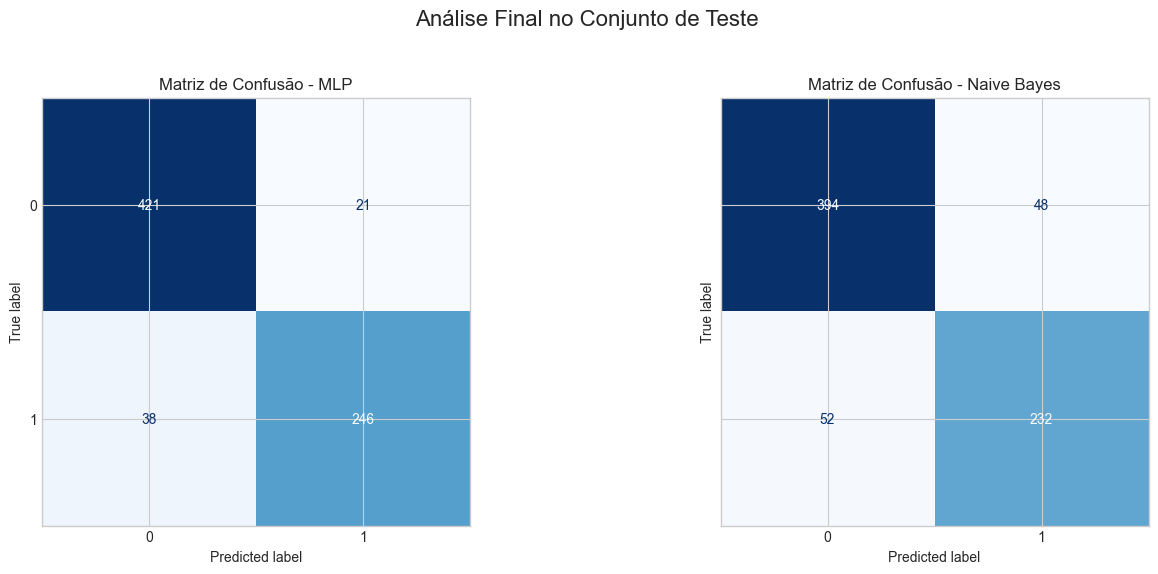

Precis√£o (Dropout)  Recall (Dropout)  F1-Score (Dropout)
MLP                      0.9213            0.8662              0.8929
Naive Bayes              0.8286            0.8169              0.8227

In [25]:
final_results = {}

for name, pipeline in best_estimators.items():
    print(f"Avaliando o melhor modelo: {name}...")
    
    y_pred = pipeline.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    dropout_metrics = report['1']
    final_results[name] = {
        'Precis√£o (Dropout)': dropout_metrics['precision'],
        'Recall (Dropout)': dropout_metrics['recall'],
        'F1-Score (Dropout)': dropout_metrics['f1-score']
    }

fig, axes = plt.subplots(1, len(best_estimators), figsize=(14, 6), sharey='row')
fig.suptitle('An√°lise Final no Conjunto de Teste', fontsize=16)

for i, (name, pipeline) in enumerate(best_estimators.items()):
    ax = axes[i] if len(best_estimators) > 1 else axes
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matriz de Confus√£o - {name}')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

results_df = pd.DataFrame.from_dict(final_results, orient='index')
results_df = results_df.round(4) 

display(results_df)

#### An√°lise do Modelo MLP (Multi-Layer Perceptron)

O modelo MLP alcan√ßou um excelente **F1-Score** de 0.8929 para a classe Dropout. Este resultado √© um forte indicativo de um modelo bem-sucedido e equilibrado. Analisando em detalhes:

- **Recall** (Sensibilidade) de 0.8662: Significa que o modelo foi capaz de identificar corretamente 86.6% de todos os alunos que realmente iriam evadir. Na pr√°tica, de cada 100 alunos em risco, o modelo conseguiu sinalizar aproximadamente 87 para uma poss√≠vel interven√ß√£o.
- **Precis√£o** de 0.9213: Esta m√©trica mostra que, quando o modelo previu que um aluno iria evadir, ele estava certo em 92.1% das vezes. Isso demonstra uma alta confiabilidade nos alertas gerados, garantindo que os recursos de apoio sejam direcionados de forma eficiente, com poucos "alarmes falsos".

A Matriz de Confus√£o confirma essa performance:

- **Falsos Negativos**: Apenas 38 alunos que iriam evadir foram classificados incorretamente como "Graduate".
- **Falsos Positivos**: Apenas 21 alunos que iriam se formar foram classificados incorretamente como "Dropout".

#### An√°lise do Modelo Gaussian Naive Bayes

O modelo Naive Bayes tamb√©m apresentou um bom desempenho, com um **F1-Score** de 0.8227.

- **Recall** (Sensibilidade) de 0.8169: O modelo conseguiu identificar 81.7% dos alunos que de fato evadiram. Embora seja um bom resultado, ele √© notavelmente inferior √† capacidade de detec√ß√£o do MLP.
- **Precis√£o** de 0.8286: Das previs√µes de "Dropout" feitas pelo modelo, 82.9% estavam corretas. √â uma boa precis√£o, mas tamb√©m inferior √† do MLP, indicando uma taxa de "alarmes falsos" um pouco maior.

A Matriz de Confus√£o do Naive Bayes mostra:

- **Falsos Negativos**: 52 alunos em risco n√£o foram identificados.
- **Falsos Positivos**: 48 alunos seguros foram sinalizados para interven√ß√£o.